Note - data is coming from this kaggle depot:
https://www.kaggle.com/harlfoxem/housesalesprediction

In [1]:
%%javascript
// Ensure our output is sufficiently large
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Sprint 1

* Load libraries
* Load data
* Explore data for quality
* Data clean-up
* Explore data for Linear Regression Suitability
* Mechanical Feature Engineering
* Run Linear Regression
* Explore coefficients


## Load Libraries

In [2]:
# Emnsure all charts plotted automatically
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import datetime
import time

import statsmodels.api as sm

import sklearn

from sklearn import preprocessing

from sklearn_pandas import DataFrameMapper

from xgboost import XGBRegressor

from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

# Don't truncate dataframe displays columwise
pd.set_option('display.max_columns', None)

## Engineer Data: Load the data

You load the CSV data into a Pandas object. This is a common Python library to work with data in row/column format, like .csv files.

Print out top 10 rows just to get a feel for the data

In [3]:
df = pd.read_csv('kc_house_data.csv', sep=',', header=0)
display(df.head(10))
display(df.shape)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


(21613, 21)

__You should see:__

* 21613 rows of data across 21 columns (different variables)
* All data appears to be numerical

__Helpful  decoder ring for what each variable means (stuff you would get from the client)__

* __id__ a notation for a house
* __date__ Date house was sold
* __price__ Price is prediction target
* __bedrooms__ Number of Bedrooms/House
* __bathrooms__ Number of bathrooms/House
* __sqft_living__ square footage of the home
* __sqft_lot__ square footage of the lot
* __floors__ Total floors (levels) in house
* __waterfront__ House which has a view to a waterfront
* __view__ quality of view - higher == better
* __condition__ How good the condition is ( Overall ) - higher == better
* __grade__ overall grade given to the housing unit, based on King County grading system - higher == better
* __sqft_above__ square footage of house apart from basement
* __sqft_basement__ square footage of the basement
* __yr_built__ Built Year
* __yr_renovated__ Year when house was renovated
* __zipcode__ zip
* __lat__ Latitude coordinate
* __long__ Longitude coordinate
* __sqft_living15__ Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
* __sqft_lot15__ lotSize area in 2015(implies-- some renovations)

## Explore the data for quality: 

* Check  for nulls
* Check for outliers on data that is numerical

### Check for nulls

* Hint - there is insnull() function as part of dataframe, that you can use to check each field
* Thne you can se sum() across columns (axis = 0) to see how often it happens in each column


In [4]:
# Any null values
df.isnull().sum(axis = 0)

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

__What you should see__:

* All the columns have count of nulls at 0

### Check for anomalies on numerical data
* create a list of numerical columns (i.e.int64 and float 64)
    * df.select_dtypes(include=['int64','float64']).columns
    
* run a loop on that list and do a histogram for each (or other visualiation you think would be apt)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

C:\ML\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


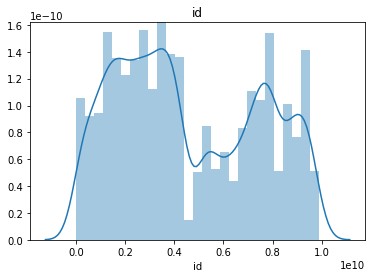

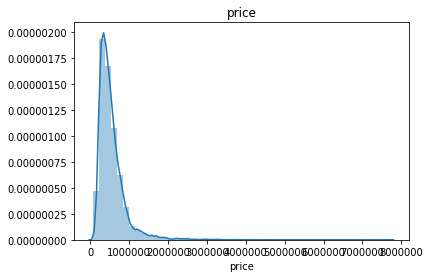

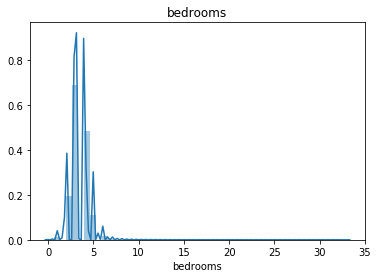

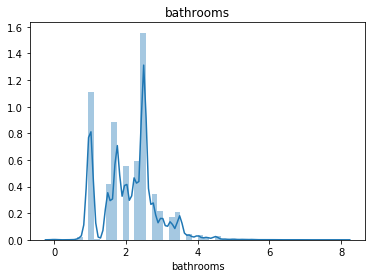

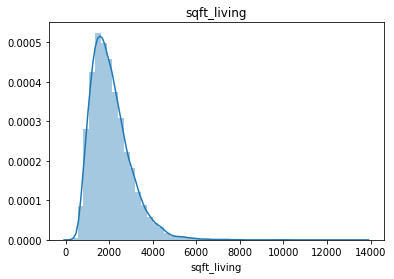

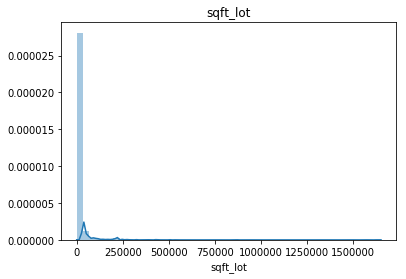

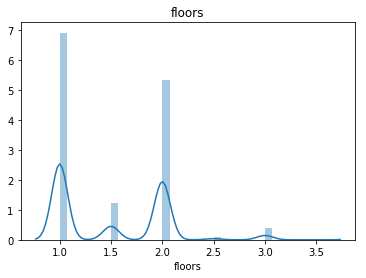

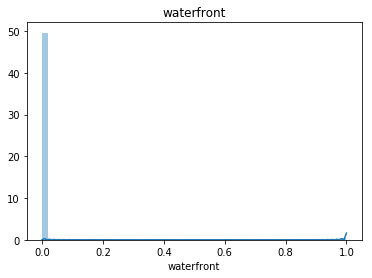

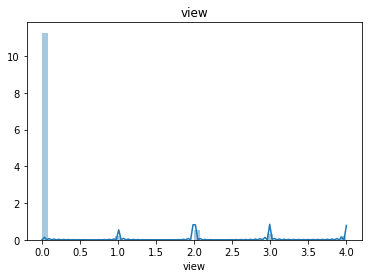

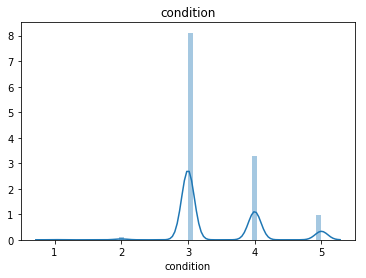

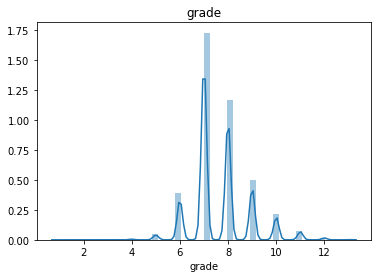

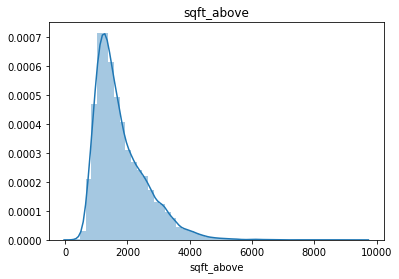

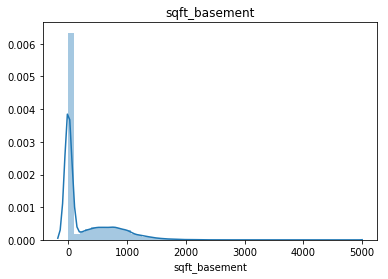

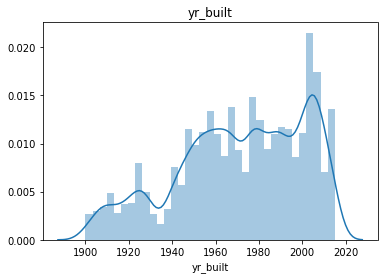

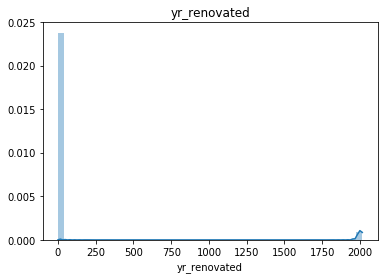

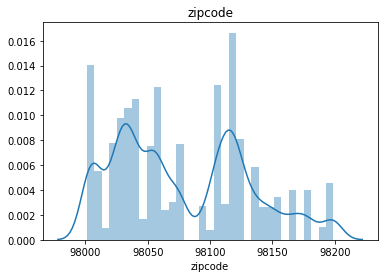

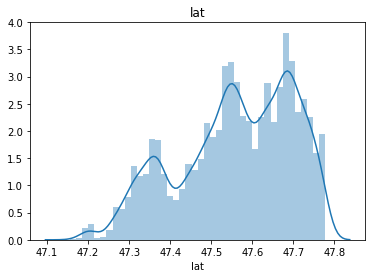

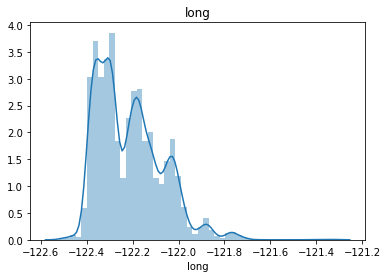

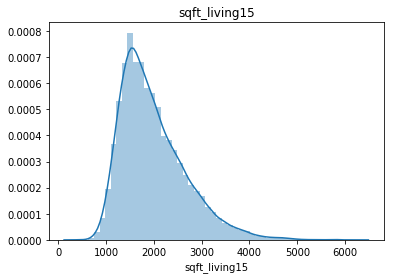

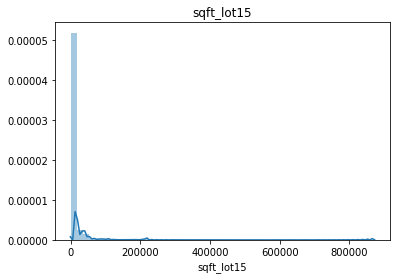

In [5]:
display(df.dtypes)

numerical_features_list = list(df.select_dtypes(include=['int64','float64']).columns)
for column in numerical_features_list:
    sns.distplot(df[column].dropna())
#     plt.hist(df[column].dropna())
    plt.title(column)
    plt.show()

__One obvious issue:__
    * Year renovated - appears to use two different standards 

__A few suspicious items:__
    * Price - long tail, which can drive huge absolute errors
    * bedrooms - long-tail and apparently some have 0?
    * bathrooms - some have 0?
    * sqft_living - long-tail
    * sqft_lot - long-tail

__Date is only non-numberical - we should check distribution__

### Data checks

* renovation year
* price
* bedrooms
* bathroom
* sqft_living
* sqft_lot

Things to do:
* Draw histograms but force more granularity (e.g. num of bins)
* do value_counts to see what distribution looks like for outliers
* etc.


__Year renovated__

0       20699
2014       91
2013       37
2003       36
2000       35
2007       35
2005       35
2004       26
1990       25
2006       24
2009       22
1989       22
2002       22
1991       20
2001       19
1998       19
1994       19
1993       19
1987       18
1983       18
1984       18
2010       18
2008       18
1986       17
1985       17
1999       17
1992       17
2015       16
1995       16
1996       15
        ...  
1975        6
1978        6
1981        5
1964        5
1965        5
1958        5
1973        5
1969        4
1972        4
1960        4
1963        4
1956        3
1945        3
1974        3
1953        3
1955        3
1976        3
1957        3
1962        2
1950        2
1967        2
1946        2
1971        2
1940        2
1954        1
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

__Price distribution__

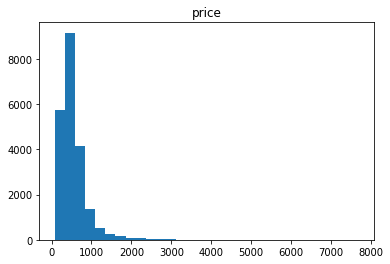

__Bedrooms__

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

__Bathrooms__

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
8.00       2
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

__sqft_living distribution__

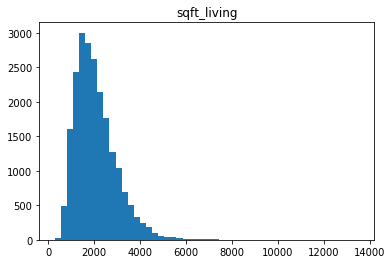

__sqft_lot distribution__

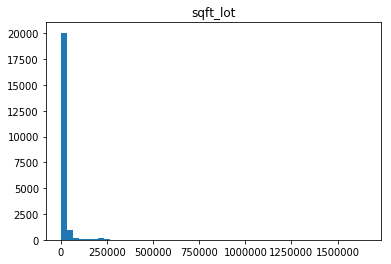

In [6]:
display(Markdown('__Year renovated__'))
display(df.yr_renovated.value_counts())
display(Markdown('__Price distribution__'))
plt.hist(df['price']/1000, bins = 30)
plt.title('price')
plt.show()
display(Markdown('__Bedrooms__'))
display(df.bedrooms.value_counts())
display(Markdown('__Bathrooms__'))
display(df.bathrooms.value_counts())
display(Markdown('__sqft_living distribution__'))
plt.hist(df['sqft_living'], bins = 50)
plt.title('sqft_living')
plt.show()
display(Markdown('__sqft_lot distribution__'))
plt.hist(df['sqft_lot'], bins = 50)
plt.title('sqft_lot')
plt.show()

__What you should see__:
* Renovation year - looks like it's all OK - 0 means no renovation
* Price - looks like it may be just a few outliers over $3M - need to check how many
* Bedrooms - just 13 with 0 (likely studios) and 1 with 33 - likely outlier
* Bathrooms - 10 with 0 - seems not possible
* sqft_living and sqft_lot - may be just very few outliers - need to check how many

### Checking data - deeper click

* long-tail of prices
* bedrooms - over 30?, 0?
* bathrooms - 0?
* sqftliving - over 8000?
* sqft_lot - over 250K, 500K

* Do counts of issues
* Display problematic ranges (i.e. literally use display)
* Etc - really anything you think will give you a better sens of rht edata

In [7]:
#Housing long tail
display(Markdown("__Houses over $3M__"))
display(df[df.price > 3000000].id.count())
display(Markdown("__Houses over $5M__"))
display(df[df.price > 5000000].id.count())
display(df[df.price > 5000000])

#Bedrooms
display(Markdown("__30+ bedrooms__"))
display(df[df.bedrooms >30])

display(Markdown("__0 bedrooms__"))
display(df[df.bedrooms == 0])

#Bathrooms
display(Markdown("__0 bathrooms__"))
display(df[df.bathrooms == 0])

#sqft_living
display(Markdown("__sqft_living__"))
display(df[df.sqft_living > 8000])

#sqft_lot
display(Markdown("__sqft_lot over 250,000__"))
display(df[df.sqft_lot > 250000].id.count())
display(Markdown("__sqft_lot over 500,000__"))
display(df[df.sqft_lot > 500000].id.count())
display(df[df.sqft_lot > 500000])



__Houses over $3M__

45

__Houses over $5M__

7

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1164,1247600105,20141020T000000,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1315,7558700030,20150413T000000,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1448,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4411,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
7252,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


__30+ bedrooms__

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


__0 bedrooms__

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,20140612T000000,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,3918400017,20150205T000000,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
3467,1453602309,20140805T000000,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
4868,6896300380,20141002T000000,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
6994,2954400190,20140624T000000,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
8477,2569500210,20141117T000000,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
8484,2310060040,20140925T000000,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
9773,3374500520,20150429T000000,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,20141223T000000,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
12653,7849202299,20150218T000000,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


__0 bathrooms__

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,20140612T000000,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1149,3421079032,20150217T000000,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
3119,3918400017,20150205T000000,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
5832,5702500050,20141104T000000,280000.0,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
6994,2954400190,20140624T000000,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
9773,3374500520,20150429T000000,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,20141223T000000,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
10481,203100435,20140918T000000,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
14423,9543000205,20150413T000000,139950.0,0,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,3980300371,20140926T000000,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


__sqft_living__

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1164,1247600105,20141020T000000,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4411,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
7252,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8092,1924059029,20140617T000000,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
12777,1225069038,20140505T000000,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
14556,2303900035,20140611T000000,2888000.0,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
18302,6072800246,20140702T000000,3300000.0,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,2001,0,98006,47.5675,-122.189,4160,18969


__sqft_lot over 250,000__

106

__sqft_lot over 500,000__

21

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1719,1020069017,20150327T000000,700000.0,4,1.00,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581
2964,2322029048,20141119T000000,999000.0,3,2.75,2830,505166,1.0,1,3,4,8,1830,1000,1962,0,98070,47.3782,-122.514,2120,21988
3949,722069232,20140905T000000,998000.0,4,3.25,3770,982998,2.0,0,0,3,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141
4441,3626079040,20140730T000000,790000.0,2,3.00,2560,982278,1.0,0,0,3,8,2560,0,2004,0,98014,47.6955,-121.861,1620,40946
4540,2522029039,20140929T000000,550000.0,3,2.00,3650,843309,2.0,0,0,4,7,3650,0,1991,0,98070,47.3627,-122.496,1870,273992
6691,2624089007,20150320T000000,1998000.0,2,2.50,3900,920423,2.0,0,0,3,12,3900,0,2009,0,98065,47.5371,-121.756,2720,411962
7077,2724079090,20150105T000000,1650000.0,4,3.25,3920,881654,3.0,0,3,3,11,3920,0,2002,0,98024,47.5385,-121.896,2970,112384
7294,1923039022,20141120T000000,700000.0,2,1.75,1679,577605,2.0,0,0,3,9,1679,0,2001,0,98070,47.4630,-122.475,1850,358934
7647,2623069031,20140521T000000,542500.0,5,3.25,3010,1074218,1.5,0,0,5,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825
7769,2323089009,20150119T000000,855000.0,4,3.50,4030,1024068,2.0,0,0,3,10,4030,0,2006,0,98045,47.4619,-121.744,1830,11700


__What you should see:__
    
* Price - looks OK - 45 houses over 3M USD and 8 over 5M USD
* Bedrooms:
    * House with 33 bedrooms is clearly a typo since modest sized home with average price - probably meant as 3
    * Houses with 0 bedrooms - some are suspicious, especially those with 0 bathrooms or those that are huge and multiple bathrooms
* Bathrooms - think 0 bathroom houses make no sense - these should be dropped
* Sqft_living - all makes sense - all outliers have lots of rooms and high price
* Sqft_lot - seems too many with big lots (100+) and those with hugest lots (over 1M) are not ver expensive and very little correlation between lot size and price, even when controlling for size of house. This will likely cause large errors, but let's leave it be

### Checking date distributrion
* Convert all dates to datetime64 type
* Group by year (df_date.dt.year) and month (df_date.dt.year) and count
* Plot as bar

* Or Google until you find the asnwer :)

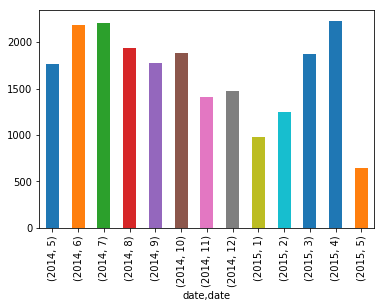

In [8]:
df_date = df["date"].astype("datetime64").copy()
df_date.groupby([df_date.dt.year, df_date.dt.month]).count().plot(kind="bar")

__What you should see:__

* Looks good, data is ineeded from interval stated and distribution is reasoanble (peak in late spring/early summer in the Northern hemisphere)
* Suspect we're missign some days in May 2015
* It appears there is some seasonality to prices (i.e. lower in winter, higher in summer) - we should add this as a feature in later sprints

## Data clean-up

__To Do__:
* Modify listing with 33 bedrooms to be 3
* Remove listings with 0 bathrooms (simply select sub-section of df where bathrooms > 0)

__WARNING: YOU SHOULD NEVER DO THIS IN PRACTICE. YOU WANT TO FIRST CHECK WITH CLIENT__

In [9]:
df_clean = df.copy()


display(Markdown("#### Modify listing with 33 bedrooms"))
display(df_clean[df_clean.bedrooms >30])
df_clean.loc[df_clean['bedrooms'] == 33, 'bedrooms'] = 3
display(df_clean[df_clean.id == 2402100895])

display(Markdown("#### Drop 0 bathrooms"))
records_before = len(df_clean.index)
display("Records Before drop {}".format(records_before))
df_clean = df_clean[df_clean.bathrooms > 0]
records_after = len(df_clean.index)
display("Records After drop {}".format(records_after))
display("Records delta {}".format(records_before - records_after))


#### Modify listing with 33 bedrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,3,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


#### Drop 0 bathrooms

'Records Before drop 21613'

'Records After drop 21603'

'Records delta 10'

## Check data for Linear Regression Suitability
* Check for colinearity
* Check for linear realtionship

### Check for co-linearity

* Create a list of numerical features (Can borrow from our initial data quality check)
* Drop id and price from list
* Use sns.heatmap() and .corr() function of our data-frame with just numberical features to draw correlation matrix



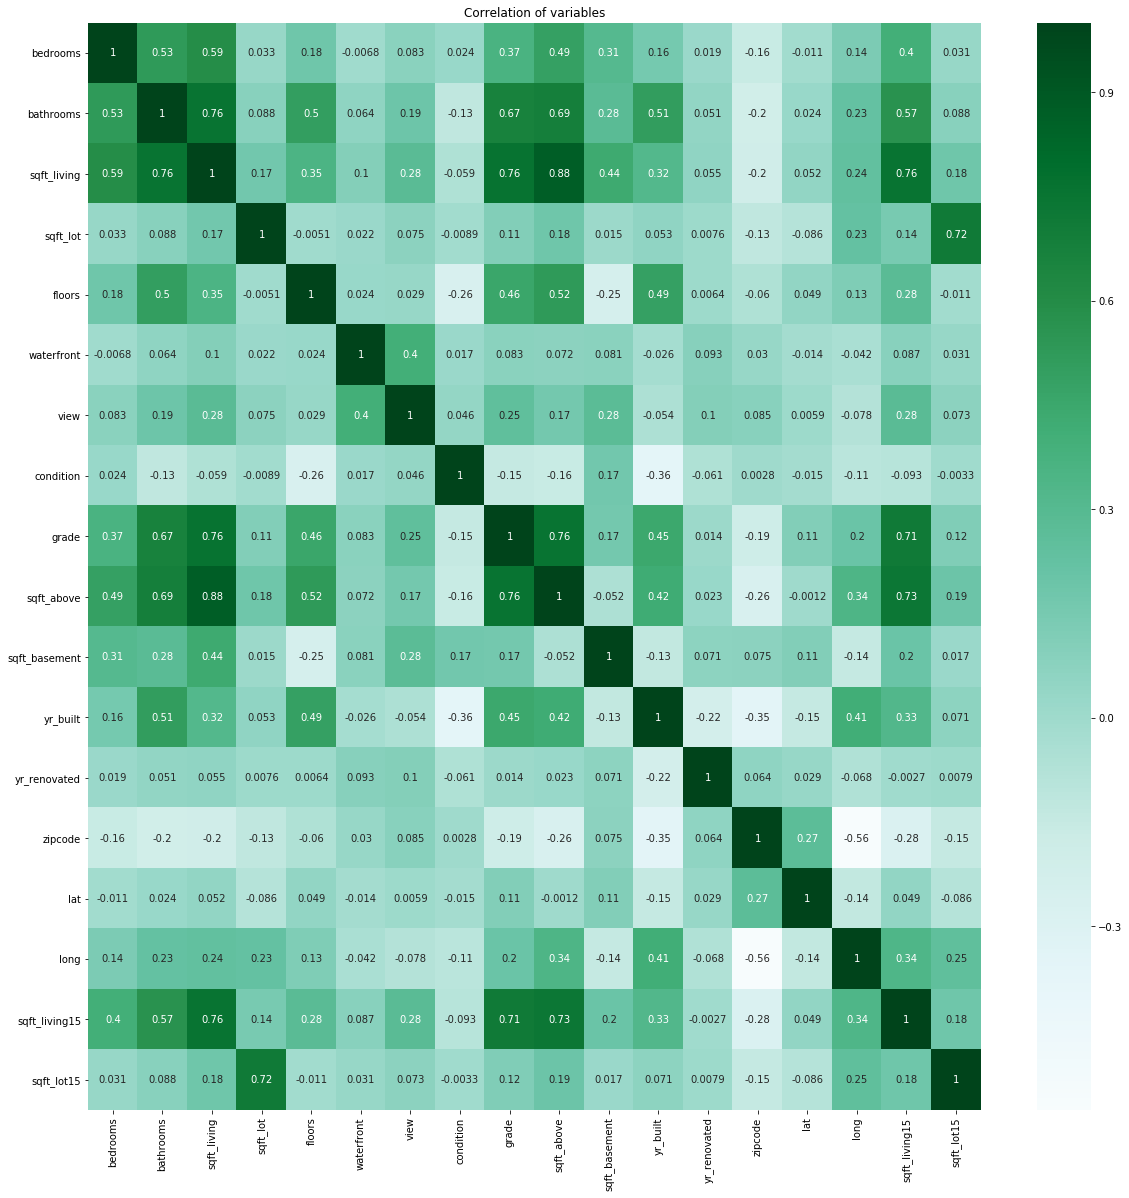

In [10]:
numerical_features_list.remove('id')
numerical_features_list.remove('price')

plt.figure(figsize=(20,20))
plt.title('Correlation of variables')
sns.heatmap(df_clean[numerical_features_list].corr(),vmax=1.0, annot=True, cmap="BuGn")
plt.show()

__What you should see__:

* Variables that are highly positively correlated:
    * sqft_above and sqft_living - we should keep sqft_living only
    * sqft_living15 and sqft_lot15 with non-15 values - let's keep non-15 values

* Variables that have high correlation, but we should probably keep:
    * Bathrooms with sqft_living
    * Grade with sqft_living
  
    

### Check for linear relationships

* We should only show relationship for variables we know will have linear relationship and where no correlation:

* Createa a list of numerical variables (Can borrown from previous step)
* remove varialbes that we know can't work or have correlation:
    * Won't work: Lat, long
    * Might work, but requires one-hot encoding: zip-code
    * Corelation: sqft_living15, sqft_lot15
    
* Run a loop and do a sns.jointplot() on price + each variable
    * extra - you could do 1 LR OLS regression plot to see if LR will pick-up on it sns.regplot()

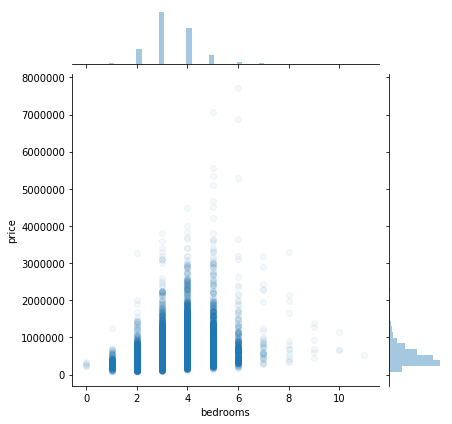

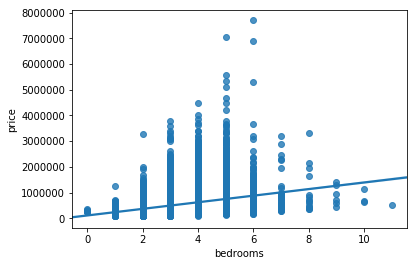

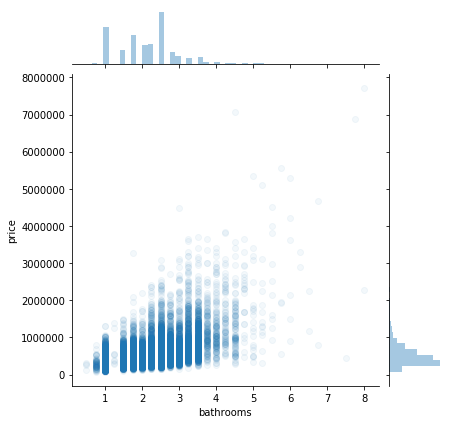

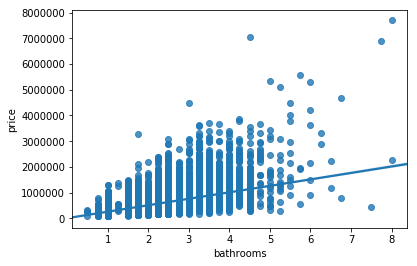

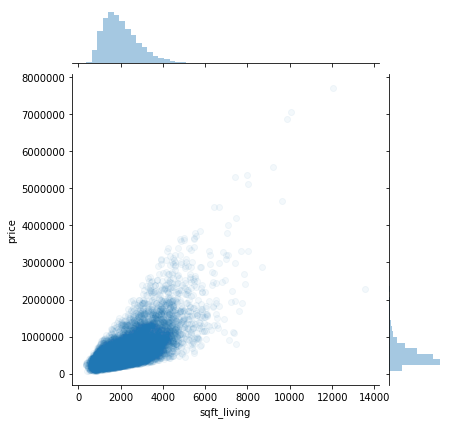

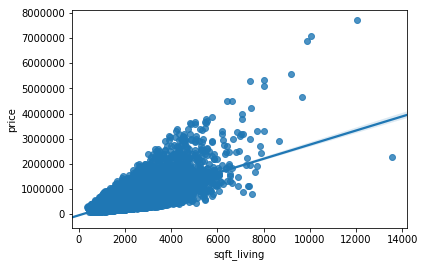

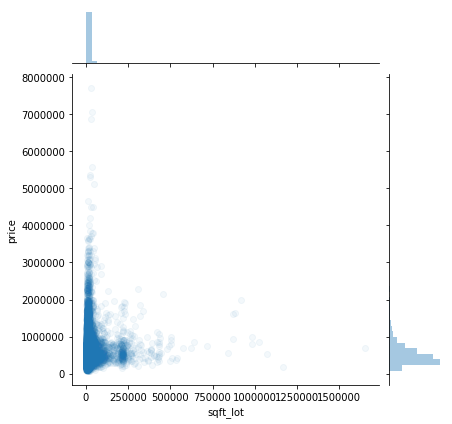

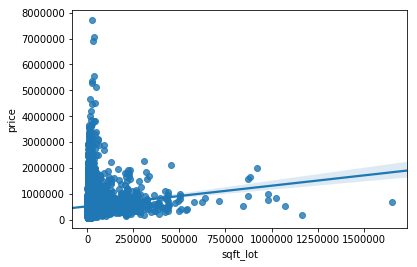

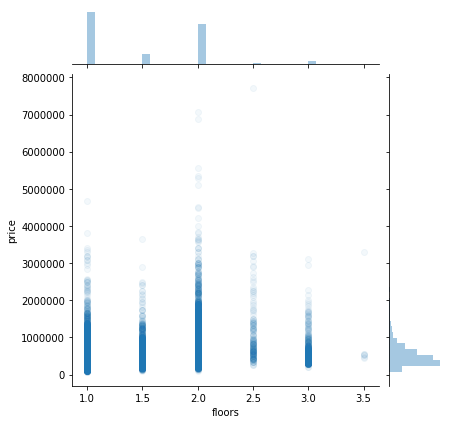

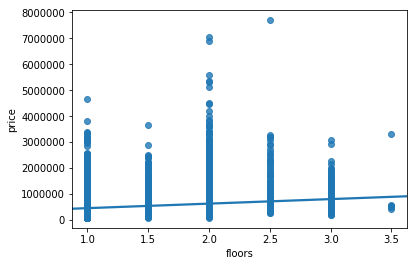

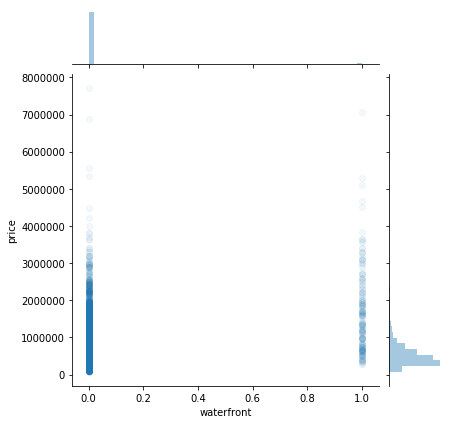

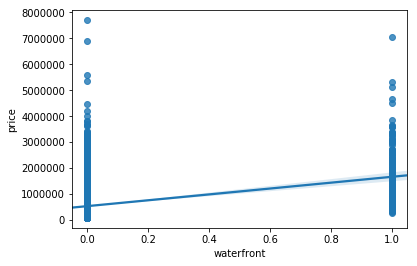

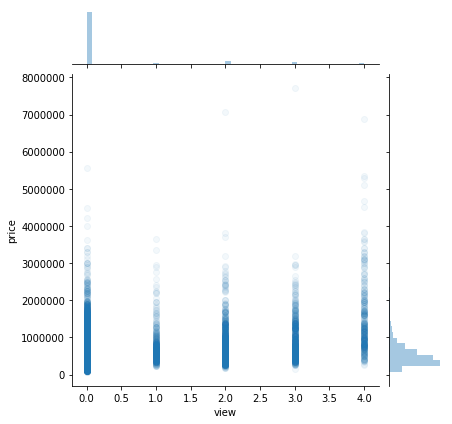

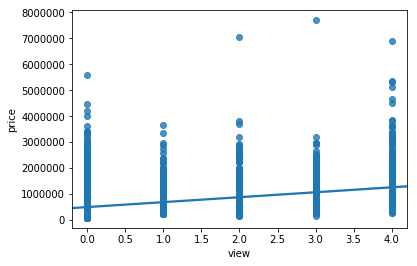

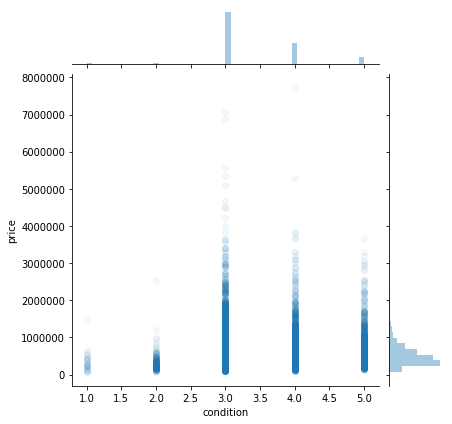

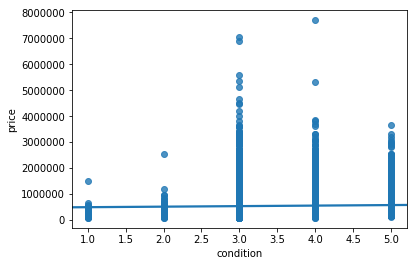

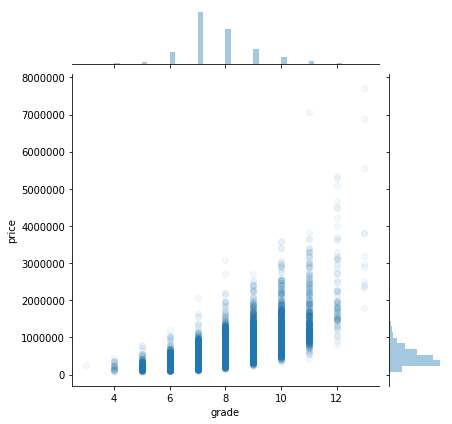

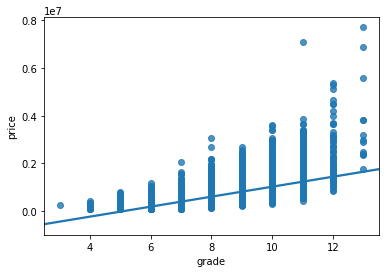

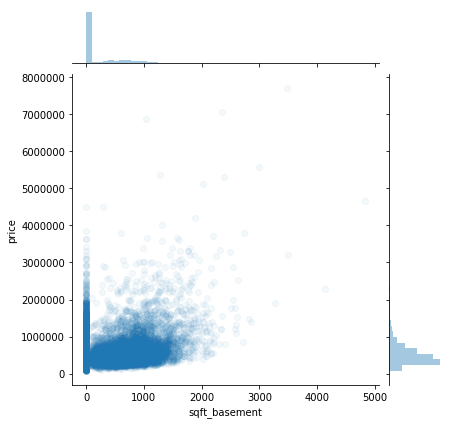

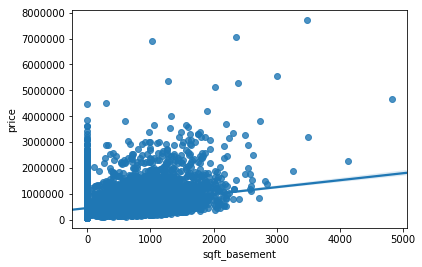

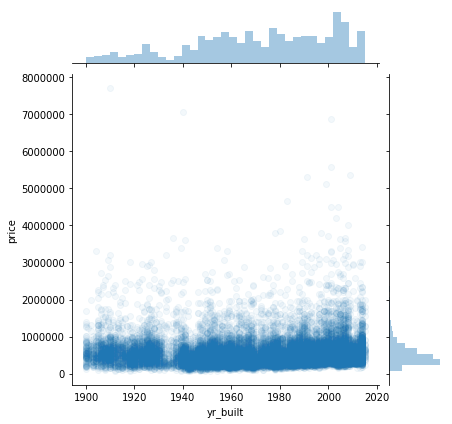

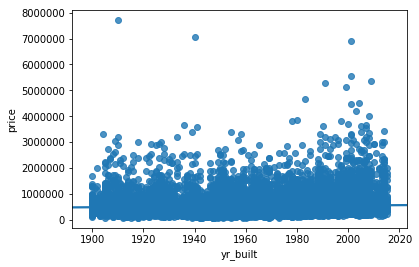

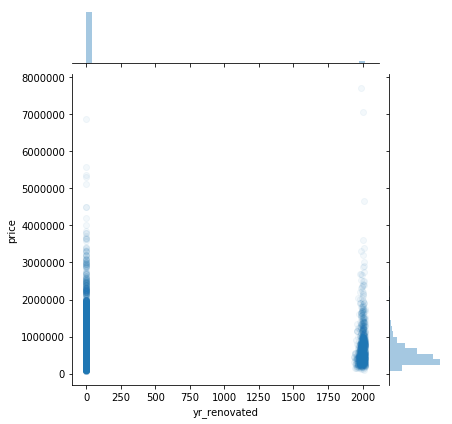

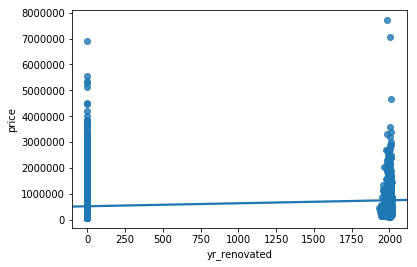

In [11]:
lr_test_features = numerical_features_list.copy()

remove_list = ["lat", "long", "zipcode", "sqft_living15", "sqft_lot15", "sqft_above"]
for item in remove_list:
    lr_test_features.remove(item)
    
for item in lr_test_features:
    sns.jointplot(df_clean[item], df_clean["price"], alpha = 0.05)
    plt.show()
    sns.regplot(df_clean[item], df_clean["price"])
    plt.show()
    
    


__What you should see and what to do about it__:
* Bedrooms - somewhat liner to 6, but then it's not -> make it one-hot
* Bathrooms - mostly linear -> keep as is
* sqft_living - mostly linear -> keep as is, but add a transofrm to bring large values into line (e.g.)
* sqft_lot - not at all linear for small lots, somewhat linear for big ones -> make it one-hot into several increments
* floors - no relationshop - > drop
* Waterfront - small relationship -> keep
* View - weak relationship ->drop
* Condiiton - no relationship -> drop
* Grade - solid link but not super-linear -> make into one-hot as will be hard to make a transformaiton
* sqft_basement -> the no basement is tripping us up -> requires thoughful FE, let's adress in future sprint
* yr_built - no relationship -> drop
* yr_renovated - would need to look at what it looks like within only those renovated and then decide

__We need to explore just a bit more to figure out what to do with following:__

* sqft-living - how to best transform larger values?
    * Let's try squaring the sqft_living and then normalizing
* sqft_lot - where to draw buckets?
    * let's draw 3 seperate scatters in 50K, 50K to 500K and over 500K
* yr_renovated - is there relationship for those renovated
    * Let's show what non-zero renovation looks like


'Sqft_living'

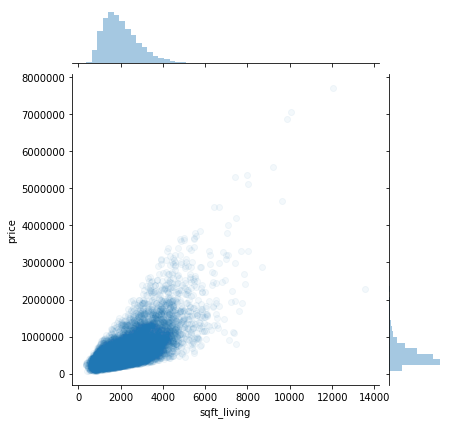

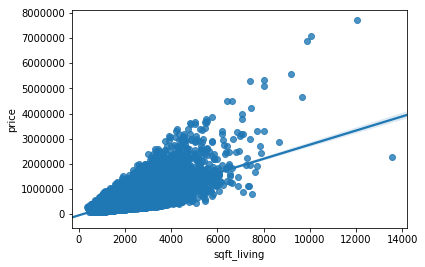

'Sqft_living - after cubing'

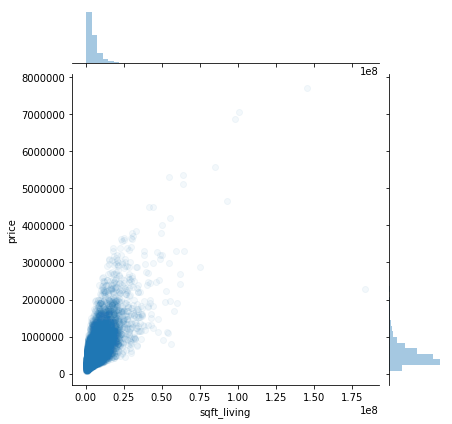

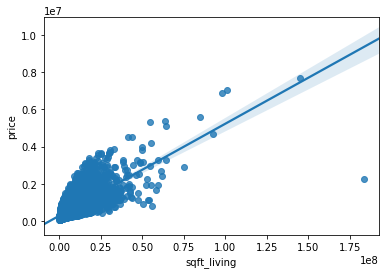

'sqft_lot under 50K'

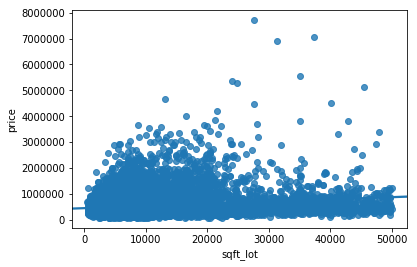

'sqft_lot - 50K to 500K'

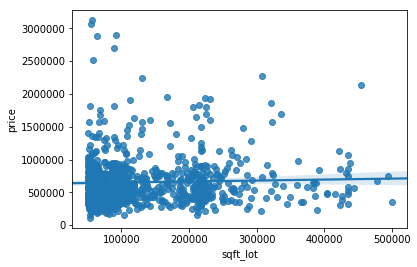

'sqft_lot - Over 500K'

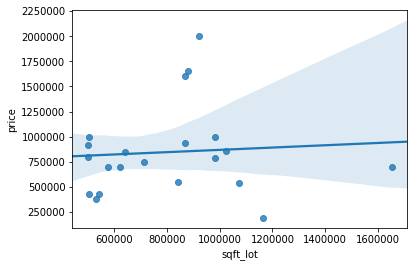

'yr_renovated'

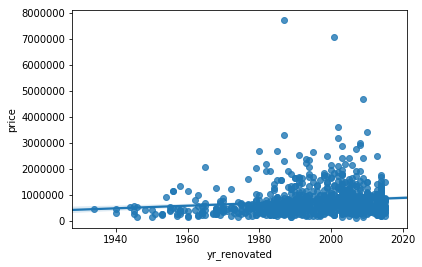

In [12]:
display("Sqft_living")
sns.jointplot(df_clean["sqft_living"], df_clean["price"], alpha = 0.05)
plt.show()
sns.regplot(df_clean["sqft_living"], df_clean["price"])
plt.show()
display("Sqft_living - after cubing")
sns.jointplot(df_clean["sqft_living"].apply(np.square), df_clean["price"], alpha = 0.05)
plt.show()
sns.regplot(df_clean["sqft_living"].apply(np.square), df_clean["price"])
plt.show()

display("sqft_lot under 50K")
sns.regplot(df_clean[df_clean.sqft_lot < 50000].sqft_lot,df_clean[df_clean.sqft_lot < 50000].price)
plt.show()
display("sqft_lot - 50K to 500K")
sns.regplot(df_clean[(df_clean.sqft_lot >= 50000) & (df_clean.sqft_lot < 500000)].sqft_lot,df_clean[(df_clean.sqft_lot >= 50000) & (df_clean.sqft_lot < 500000)].price)
plt.show()
display("sqft_lot - Over 500K")
sns.regplot(df_clean[(df_clean.sqft_lot >= 500000)].sqft_lot,df_clean[df_clean.sqft_lot >= 500000].price)
plt.show()


display("yr_renovated")
sns.regplot(df_clean[df_clean.yr_renovated >0].yr_renovated,df_clean[df_clean.yr_renovated >0].price)
plt.show()


__What you should see and do:__

* It looks likes squaring the sqft_living makes it far more linear - we should keep
* There is not realtionship in sqft_lot -> we should drop for now
* Yr_renovated -> appears to be a relationship, may make sense to add as a feature in future sprints as one hot (for no renovaiton, and then buckets for decades since renovated)

## Mechanical feature engineering
* We should start with a few features and then add them slowly - use conclusions from above as starting point
* Will need to make some into one-hot (e.g. bedrooms, grade)
* For others will need custom transfrom (E.g. squaring sqft_living)
* For some continous variables, probably a good idea to normalize (e.g. number of bathrooms)
* Some require nothing (e.g. WAterfront - already one-hot :))
* Some are interestign but we will puruse in future sprints (e.g. sqft_basement, yr_renovated, month)

* Since few variables - you can just list each individually and what transformation(s) you want to do


In [13]:
# We use capitals for constant variables
TARGET = 'price'

def square_x(x):
    return x * x 

preprocessing_steps = ([
    ('waterfront', None),
    (['bathrooms'], preprocessing.StandardScaler()),
    (['sqft_living'],[preprocessing.FunctionTransformer(square_x),preprocessing.StandardScaler()]),
    ('bedrooms', preprocessing.LabelBinarizer()),
    ('grade', preprocessing.LabelBinarizer())
])


mapper_features_s1 = DataFrameMapper(preprocessing_steps)
   

np_transformed_features_s1 = mapper_features_s1.fit_transform(df_clean.copy())
df_transformed_features_s1 = pd.DataFrame(data = np_transformed_features_s1, columns = mapper_features_s1.transformed_names_)

mapper_target_s1 = DataFrameMapper([(['price'],None)])
numpy_transform_target_s1 = mapper_target_s1.fit_transform(df_clean[[TARGET]].copy())

df_transformed_target_s1 = pd.DataFrame(data = numpy_transform_target_s1, columns = ['price'])

C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Standa

## Train the Linear Model


### Split data

* Let's split at 80/20 train/test

In [14]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features_s1, df_transformed_target_s1, test_size=0.2, random_state=42)

### Train the model and see regression results on train test-sets

Use statsmodels OLS model

In [15]:
sm_lm_model = sm.OLS(y_train, sm.add_constant(X_train))

sm_lm_model_fit_s1 = sm_lm_model.fit()

display(sm_lm_model_fit_s1.summary())




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1245.
Date:                Tue, 11 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:27:38   Log-Likelihood:            -2.3721e+05
No. Observations:               17282   AIC:                         4.745e+05
Df Residuals:                   17257   BIC:                         4.747e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.183e+05   2.97e+04     20.788      0.000     5.6e+05    6.77e+05
waterfront   7.543e+05   1.98e+04     38.120      0.000    7.15e+05    7.93e+05
bathrooms   -5483.9281   2689.382     -2.039      0.041   -1.08e+04    -212.466
sqft_living  1.729e+05   3262.204     53.013      0.000    1.67e+05    1.79e+05
bedrooms_0  -4762.0910   9.58e+04     -0.050      0.960   -1.93e+05    1.83e+05
bedrooms_1   6.999e+04   2.99e+04      2.337      0.019    1.13e+04    1.29e+05
bedrooms_2   9.692e+04   2.57e+04      3.768      0.000    4.65e+04    1.47e+05
bedrooms_3    5.85e+04   2.53e+04      2.311      0.021    8885.034    1.08e+05
bedrooms_4   4.774e+04   2.53e+04      1.888      0.059   -1821.092    9.73e+04
bedrooms_5    6.56e+04   2.57e+04      2.548      0.011    1.51e+04    1.16e+05
bedrooms_6   5.858e+04   2.88e+04      2.035      0.042    2142.794    1.15e+05
bedrooms_7    7.15e+04   4.44e+04      1.609      0.108   -1.56e+04    1.59e+05
bedrooms_8   1.215e+04   7.63e+04      0.159      0.873   -1.37e+05    1.62e+05
bedrooms_9   1.164e+05   1.05e+05      1.109      0.267   -8.93e+04    3.22e+05
bedrooms_10  2.514e+04   1.46e+05      0.172      0.863   -2.61e+05    3.12e+05
bedrooms_11   532.9901   2.05e+05      0.003      0.998   -4.01e+05    4.02e+05
grade_3     -2.792e+05   2.04e+05     -1.372      0.170   -6.78e+05     1.2e+05
grade_4     -3.388e+05   4.63e+04     -7.311      0.000    -4.3e+05   -2.48e+05
grade_5     -3.366e+05   2.56e+04    -13.157      0.000   -3.87e+05   -2.86e+05
grade_6     -2.842e+05   2.16e+04    -13.156      0.000   -3.27e+05   -2.42e+05
grade_7      -2.15e+05    2.1e+04    -10.232      0.000   -2.56e+05   -1.74e+05
grade_8     -1.361e+05   2.09e+04     -6.500      0.000   -1.77e+05    -9.5e+04
grade_9     -1.236e+04    2.1e+04     -0.589      0.556   -5.35e+04    2.87e+04
grade_10     1.358e+05   2.15e+04      6.319      0.000    9.37e+04    1.78e+05
grade_11     3.114e+05   2.36e+04     13.177      0.000    2.65e+05    3.58e+05
grade_12     6.082e+05   3.26e+04     18.666      0.000    5.44e+05    6.72e+05
grade_13     1.165e+06   6.98e+04     16.687      0.000    1.03e+06     1.3e+06
==============================================================================
Omnibus:                     6760.500   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83130.203
Skew:                           1.533   Prob(JB):                         0.00
Kurtosis:                      13.298   Cond. No.                     1.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.6e-28. This might indicate that there are
strong multicollinearity proble

__What you should see__:

* Adjusted R2 of .633 is not bad for first attempt

__Interpreting coefficients__:

* const is 614K which is effectively average price, so coefficients will be things to move it higher or lower

* Coefficients are a little difficult to interpret for some because we transfomed them (E.g. sqft_living is squared + normalized and bathrooms are normalized)

* Most make sense, but a few suspicious items:
    * More bathrooms drives house price down - opposite of what we saw -> this is likely due to co-linearity of sqft_living (0.76 correlation)
    * Grades don't follow a linear pattern at lower end of grade scale (i.e. lowest grade doesn't take away as much value as higher ones oneS) -> likely overfitting
    
* Statistically speaking some should be killed b/c P>[t] is not less then .05 (95% CI)
    * Bedrooms 0 - massive range of where coefficient could be
    * Bedrooms 4,7,8,9,10 and 11 - likely driven by low N
    * Grade 3 and 9 - likely driven by low N
    
* Interesting tid-bits
    * Being waterfront adds 800K dollars to the house value


### Examine accuracy on test data-set
* Run prediciton on un-seen data and see average error on seen and unseen data
    * model_fit.predict()
        * Remember to use sm.addconstant(X_train) so that matrices match
        
* For MAE, you can use sklearn.metrics.mean_absolute_error(y_train, y_predicted)
    * just make sure both matrices are in same shape
* For MAPE, you need to write your own function (Remember formula is Average of ABS(actual-predicted)/true))

In [16]:
# See how well we did
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

y_lr_train = sm_lm_model_fit_s1.predict(sm.add_constant(X_train))
y_lr_test = sm_lm_model_fit_s1.predict(sm.add_constant(X_test))

# display(Markdown('###### Performance on training set'))
display('Linear model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train.values.ravel(), y_lr_train.values)))
display('Linear model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_train.values.ravel(), y_lr_train.values)*100))

# display(Markdown('###### Performance on test set'))
display('Linear model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test.values.ravel(), y_lr_test.values)))
display('Linear model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test.values.ravel(), y_lr_test.values)*100))




'Linear model train set MAE: $149559'

'Linear model train set MAPE: 30.89%'

'Linear model test set MAE: $153135'

'Linear model train set MAPE: 31.58%'

__What you should see:__

* MAE of ~150,000 dollars
* MAPE of 32% is decent first attempt, but not great
* test set error is close enough to train that not too worried about over-fittign just yet

### Test that model

* Check residuals are normally distributed across all estiamtes
* Check residuals are normally distributed by each point
* Check no heteroskedacity 

* you'll likely need to calcualte residuals in absolute and as percentage in a seperate data-frame
* Then you cna just use histogram and scatter plots to see what's going on

'Distribution of residuals'

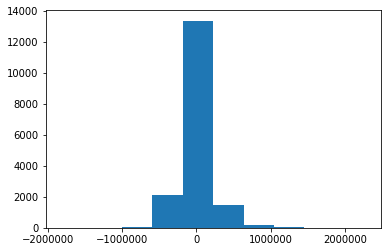

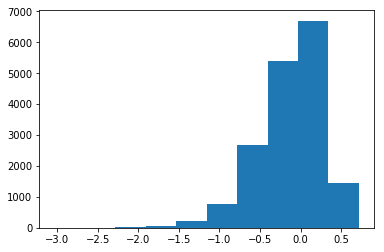

'Residuals vs price'

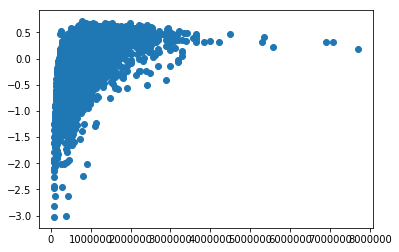

'Residuals vs price for homes under 1M USD'

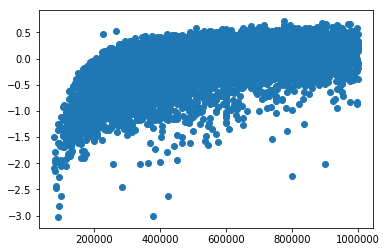

'Residuals vs price for homes over 1M USD'

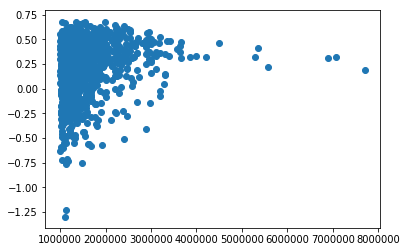

In [17]:
df_residuals = y_train.copy()
df_residuals['residual_norm'] = df_residuals.price - y_lr_train.values
df_residuals['residual_perc'] = (df_residuals.price - y_lr_train.values)/df_residuals.price
df_residuals['residual_perc_abs'] = np.abs(df_residuals.price - y_lr_train.values)/df_residuals.price


display("Distribution of residuals")
plt.hist(df_residuals['residual_norm'])
plt.show()
plt.hist(df_residuals['residual_perc'])
plt.show()

display("Residuals vs price")
plt.scatter(df_residuals.price, df_residuals.residual_perc)
plt.show()
display("Residuals vs price for homes under 1M USD")
plt.scatter(df_residuals[df_residuals.price <1000000].price, df_residuals[df_residuals.price <1000000].residual_perc)
plt.show()
display("Residuals vs price for homes over 1M USD")
plt.scatter(df_residuals[df_residuals.price >1000000].price, df_residuals[df_residuals.price >1000000].residual_perc)
plt.show()




__What you should see:__

* We definitely have a few problems here
* Residuals are not normally distribvuted - more negative errors
* Residuals are not normally distributed across points - very negative skew at lower prices
* There is definite heteroskedacity - bigger errors (%wise) for smaller price points - i.e. we think house should be priced up 3x more then actual sale price

## Explore error

* Let's see if these high-error low-priced homes have something in common
* Basically add residual in percentage to the df_transformed_features_s1
* Then predict all prices
* Then calculate residuals
* Then for each feature do a histogram of distribution in two steps:
    * Do it only on homes under 1,000,000 USD 
    * Plot seperte distributions for high-error and low-error homes (let's dre the bad error at more then 75%)
   

,waterfront,bathrooms,sqft_living,bedrooms_0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,price,price_predicted,residual_perc
0,0.0,-1.450934,-0.698759,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,221900.0,348859.273719,-0.572146
1,0.0,0.174600,0.265473,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,538000.0,506697.693518,0.058183
2,0.0,-1.450934,-0.846654,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,292522.300782,-0.625124
3,0.0,1.149921,-0.245694,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,604000.0,402184.293237,0.334132
4,0.0,-0.150507,-0.434231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,510000.0,466408.701918,0.085473
6,0.0,0.174600,-0.412250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,257500.0,389493.316903,-0.512595
7,0.0,-0.800720,-0.748482,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,291850.0,336694.386655,-0.153656
8,0.0,-1.450934,-0.370226,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,229500.0,405675.168379,-0.767648
9,0.0,0.499707,-0.295548,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,323000.0,407892.733611,-0.262826
10,0.0,0.499707,1.388089,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,662500.0,777992.043434,-0.174328


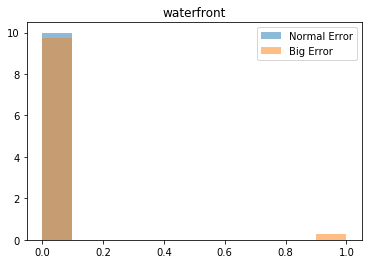

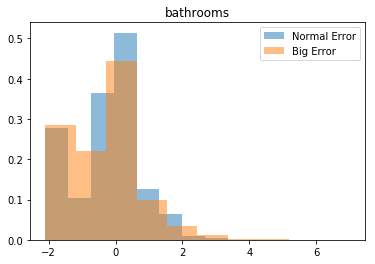

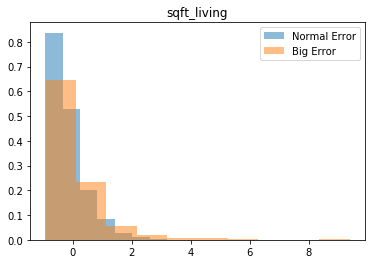

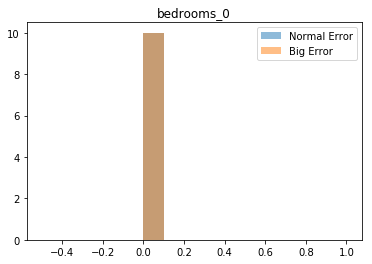

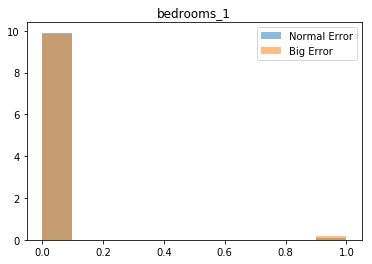

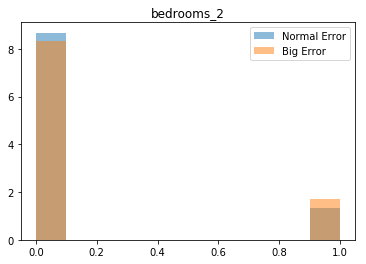

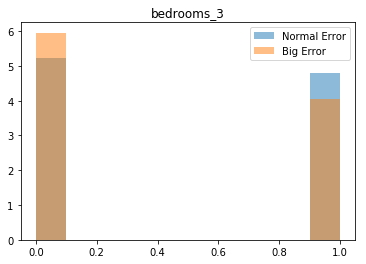

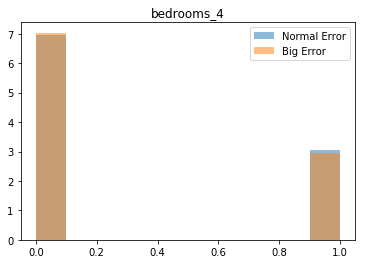

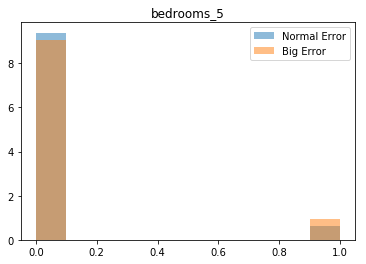

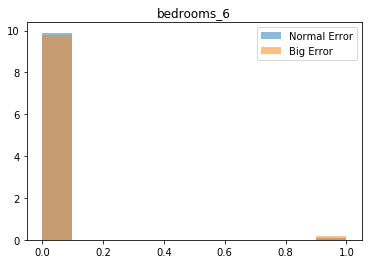

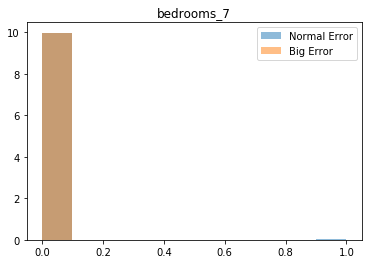

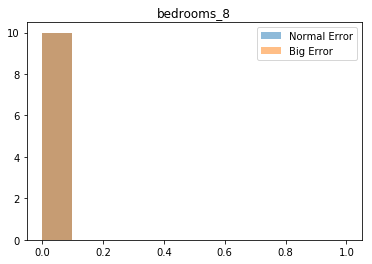

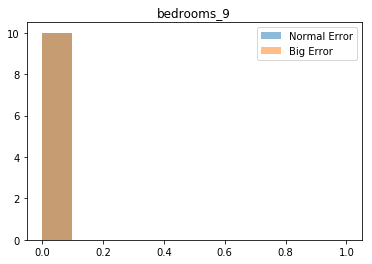

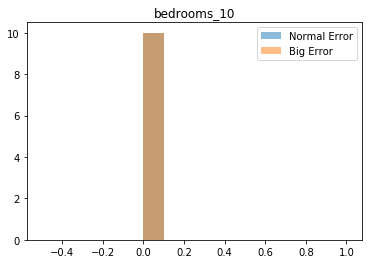

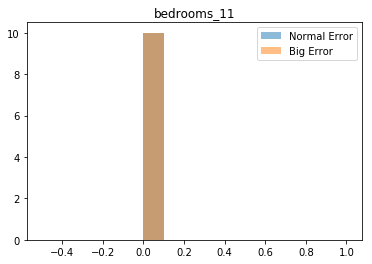

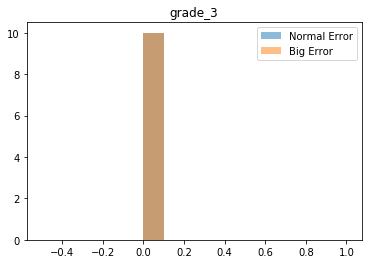

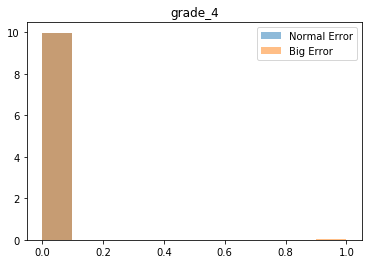

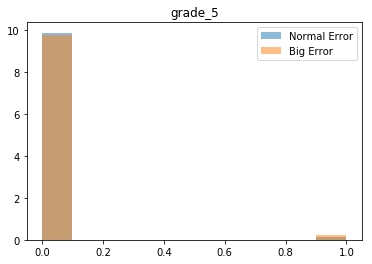

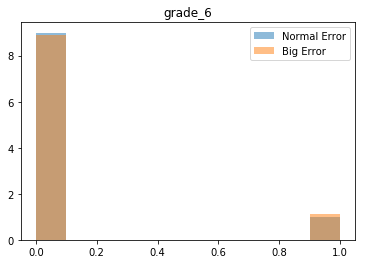

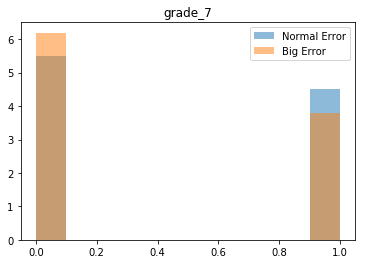

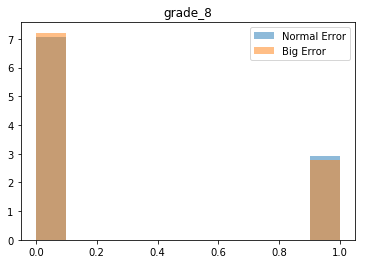

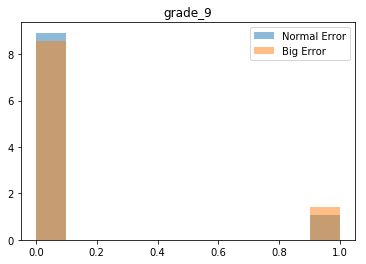

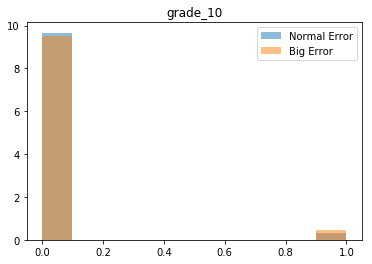

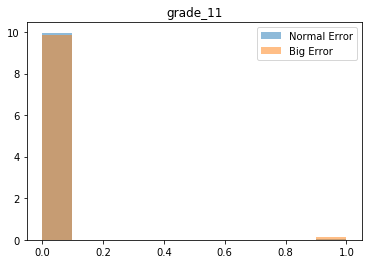

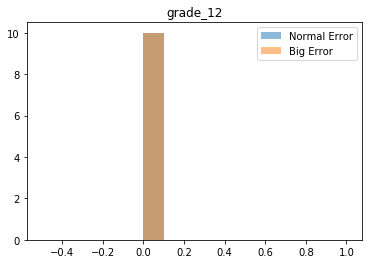

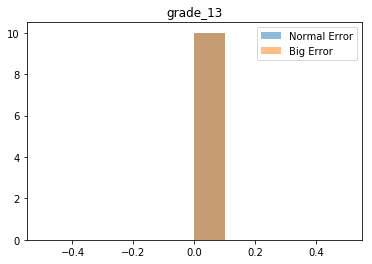

In [18]:
df_error = df_transformed_features_s1.copy()
df_error['price'] = numpy_transform_target_s1
df_error["price_predicted"] = sm_lm_model_fit_s1.predict(sm.add_constant(df_transformed_features_s1))
df_error['residual_perc'] = (df_error.price - df_error.price_predicted)/df_error.price

df_error = df_error[df_error.price < 1000000]

display(df_error.head(10))

features_list = list(df_error.columns)
features_list.remove('price')
features_list.remove('price_predicted')
features_list.remove('residual_perc')

for column in features_list:
    plt.hist(df_error[df_error['residual_perc'] > -0.75][column], alpha=0.5, label='Normal Error',density = True)
    plt.hist(df_error[df_error['residual_perc'] < -0.75][column], alpha=0.5, label='Big Error',density = True)
    plt.legend(loc='upper right')
    plt.title(column)
    plt.show()
        

__What you should see:__

* Nothing really jumps out - distribution of things with normal errors and really bad error is pretty similar
* It's probably that one of the missing variables is playing a big role
* We should investigate that in sprint 2 or 3


# Sprint 2

* Add in remaining features from sprint 1
* Re-run OLS LR
* Remove features that are not statistically significant
* Re-run OLS LR
* Join new data and explore if predicitive
* Add new data to the data-set
* Re-run OLS LR
* Re-run with XGBoost

## Add in remaining features from sprint 1
* yr_renovated
    * create fucntion to bucket in an intelligent way (by decade)
    * create transform functionto apply along an entire series

* sqft_basement
    * create fucntion to bucket in an intelligent way
    * create transform functionto apply along an entire series
    
* month one-hot
    * convert date column to datetiem64
    * create new column month that is just month porton of date

* add new variables to dataframe mapper
* run dataframe mapper
    


In [19]:
def yr_renovated_fe(x):
    if x == 0:
        return 0      
    else:
        return (np.floor((x - 1930) / 10))
    
    
def yr_renovated_transform(x):
    x = np.apply_along_axis(yr_renovated_fe,1, x)
    return x
    
def sqft_baseemnt_fe(x):
    if x == 0:
        return 0
    else:
        return(np.floor(x/1000) + 1)

def sqft_baseemnt_transform(x):
    x = np.apply_along_axis(sqft_baseemnt_fe,1, x)
    return x

df_clean["date"] = df_clean["date"].astype("datetime64")
df_clean['month'] = df_clean.date.dt.month
        
preprocessing_steps_s2_1 = ([
    ('waterfront', None),
    (['bathrooms'], preprocessing.StandardScaler()),
    (['sqft_living'],[preprocessing.FunctionTransformer(square_x),preprocessing.StandardScaler()]),
    ('bedrooms', preprocessing.LabelBinarizer()),
    ('grade', preprocessing.LabelBinarizer()),
    (['yr_renovated'], [preprocessing.FunctionTransformer(yr_renovated_transform),preprocessing.LabelBinarizer()]),
    (['sqft_basement'], [preprocessing.FunctionTransformer(sqft_baseemnt_transform),preprocessing.LabelBinarizer()]),
    (['month'], preprocessing.LabelBinarizer())
])


mapper_features_s2_1 = DataFrameMapper(preprocessing_steps_s2_1)
   

np_transformed_features_s2_1 = mapper_features_s2_1.fit_transform(df_clean.copy())
df_transformed_features_s2_1 = pd.DataFrame(data = np_transformed_features_s2_1, columns = mapper_features_s2_1.transformed_names_)


display(df_transformed_features_s2_1.head(10))


C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by valida

,waterfront,bathrooms,sqft_living,bedrooms_0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,yr_renovated_0,yr_renovated_1,yr_renovated_2,yr_renovated_3,yr_renovated_4,yr_renovated_5,yr_renovated_6,yr_renovated_7,yr_renovated_8,sqft_basement_0,sqft_basement_1,sqft_basement_2,sqft_basement_3,sqft_basement_4,sqft_basement_5,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.0,-1.450934,-0.698759,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.174600,0.265473,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-1.450934,-0.846654,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.149921,-0.245694,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,-0.150507,-0.434231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.100561,4.477849,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.174600,-0.412250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,-0.800720,-0.748482,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,-1.450934,-0.370226,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.499707,-0.295548,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Re-run OLS Linear Regression

### Train OLS LR with new features

In [20]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features_s2_1, df_transformed_target_s1, test_size=0.2, random_state=42)

sm_lm_model_s2_1 = sm.OLS(y_train, sm.add_constant(X_train))

sm_lm_model_fit_s2_1 = sm_lm_model_s2_1.fit()

display(sm_lm_model_fit_s2_1.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     687.8
Date:                Tue, 11 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:27:44   Log-Likelihood:            -2.3677e+05
No. Observations:               17282   AIC:                         4.736e+05
Df Residuals:                   17234   BIC:                         4.740e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.945e+05   2.77e+04     21.476      0.000     5.4e+05    6.49e+05
waterfront       7.232e+05   1.95e+04     37.153      0.000    6.85e+05    7.61e+05
bathrooms       -1.057e+04   2648.246     -3.992      0.000   -1.58e+04   -5381.978
sqft_living      1.622e+05   3530.726     45.927      0.000    1.55e+05    1.69e+05
bedrooms_0       3.159e+04   9.35e+04      0.338      0.735   -1.52e+05    2.15e+05
bedrooms_1       7.083e+04   2.97e+04      2.383      0.017    1.26e+04    1.29e+05
bedrooms_2       9.908e+04   2.57e+04      3.860      0.000    4.88e+04    1.49e+05
bedrooms_3       6.193e+04   2.53e+04      2.448      0.014    1.23e+04    1.12e+05
bedrooms_4       5.077e+04   2.53e+04      2.008      0.045    1210.077       1e+05
bedrooms_5       6.017e+04   2.57e+04      2.339      0.019    9742.685    1.11e+05
bedrooms_6       5.577e+04   2.86e+04      1.950      0.051    -287.031    1.12e+05
bedrooms_7       8.013e+04   4.37e+04      1.836      0.066   -5436.161    1.66e+05
bedrooms_8       5.534e+04   7.46e+04      0.742      0.458    -9.1e+04    2.02e+05
bedrooms_9       6.855e+04   1.02e+05      0.669      0.503   -1.32e+05    2.69e+05
bedrooms_10      1.081e+05   1.43e+05      0.757      0.449   -1.72e+05    3.88e+05
bedrooms_11     -1.478e+05      2e+05     -0.737      0.461   -5.41e+05    2.45e+05
grade_3          -2.73e+05   1.98e+05     -1.376      0.169   -6.62e+05    1.16e+05
grade_4         -3.486e+05   4.54e+04     -7.675      0.000   -4.38e+05    -2.6e+05
grade_5         -3.409e+05   2.54e+04    -13.425      0.000   -3.91e+05   -2.91e+05
grade_6         -3.006e+05   2.16e+04    -13.918      0.000   -3.43e+05   -2.58e+05
grade_7         -2.385e+05   2.11e+04    -11.322      0.000    -2.8e+05   -1.97e+05
grade_8         -1.539e+05    2.1e+04     -7.334      0.000   -1.95e+05   -1.13e+05
grade_9         -1.567e+04    2.1e+04     -0.745      0.456   -5.69e+04    2.55e+04
grade_10         1.431e+05   2.16e+04      6.636      0.000    1.01e+05    1.85e+05
grade_11         3.385e+05   2.37e+04     14.303      0.000    2.92e+05    3.85e+05
grade_12         6.586e+05   3.22e+04     20.451      0.000    5.96e+05    7.22e+05
grade_13         1.126e+06   6.97e+04     16.139      0.000    9.89e+05    1.26e+06
yr_renovated_0  -1.197e+04   1.24e+04     -0.968      0.333   -3.62e+04    1.23e+04
yr_renovated_1   4.409e+04   7.39e+04      0.597      0.551   -1.01e+05    1.89e+05
yr_renovated_2   1.973e+04   4.83e+04      0.409      0.683   -7.49e+04    1.14e+05
yr_renovated_3  -3.372e+04   3.73e+04     -0.904      0.366   -1.07e+05    3.94e+04
yr_renovated_4   4.513e+04   3.09e+04      1.459      0.145   -1.55e+04    1.06e+05
yr_renovated_5   9.785e+04   2.09e+04      4.680      0.000    5.69e+04    1.39e+05
yr_renovated_6    1.27e+05      2e+04      6.361      0.000

__What you should see:__
* Adjsut R2 got better (.65 from .63)
* We have lots of coefficients that are not statistically significant

* Let's run MAE and MAPE to see if it improves accuracy


### Test re-run OLS regression

* Predict train and test
* Calculate MAPE and MAE

In [21]:
y_lr_train = sm_lm_model_fit_s2_1.predict(sm.add_constant(X_train))
y_lr_test = sm_lm_model_fit_s2_1.predict(sm.add_constant(X_test))

# display(Markdown('###### Performance on training set'))
display('Linear model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train.values.ravel(), y_lr_train.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_train.values.ravel(), y_lr_train.values)))

# display(Markdown('###### Performance on test set'))
display('Linear model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test.values.ravel(), y_lr_test.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_test.values.ravel(), y_lr_test.values)))

'Linear model train set MAE: $144589'

'Linear model train set MAPE: 0.2985%'

'Linear model test set MAE: $148880'

'Linear model train set MAPE: 0.3068%'

__What you should see:__

* Our MAPE got a bit better - from 31.6% to 30.7% - YAY

### Remove variables not statistically significant 

* You can get pvalues from paramter pvalues
* Create a list of pvalues that are > 0.05 (this will be a PD Series with feature name + pvalues)
* Get just names of those features
* using pandas drop(feature_name, axis = 1, inplace = True) - drop those features from our df_transformed_features

In [22]:
drop_list = sm_lm_model_fit_s2_1.pvalues[sm_lm_model_fit_s2_1.pvalues > 0.05]
display(drop_list)
drop_list_names = drop_list.index

display(len(drop_list_names))

df_transformed_features_s2_1 = df_transformed_features_s2_1.copy()
display(df_transformed_features_s2_1.shape)

for fe_to_drop in drop_list_names:
        df_transformed_features_s2_1.drop(fe_to_drop, axis = 1, inplace = True)

display(df_transformed_features_s2_1.shape)

display(df_transformed_features_s2_1.head(10))

bedrooms_0         0.735465
bedrooms_6         0.051185
bedrooms_7         0.066438
bedrooms_8         0.458399
bedrooms_9         0.503415
bedrooms_10        0.449357
bedrooms_11        0.461076
grade_3            0.168701
grade_9            0.455990
yr_renovated_0     0.332827
yr_renovated_1     0.550820
yr_renovated_2     0.682748
yr_renovated_3     0.365958
yr_renovated_4     0.144554
sqft_basement_0    0.104363
sqft_basement_1    0.107339
dtype: float64

16

(21603, 53)

(21603, 37)

,waterfront,bathrooms,sqft_living,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,grade_4,grade_5,grade_6,grade_7,grade_8,grade_10,grade_11,grade_12,grade_13,yr_renovated_5,yr_renovated_6,yr_renovated_7,yr_renovated_8,sqft_basement_2,sqft_basement_3,sqft_basement_4,sqft_basement_5,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.0,-1.450934,-0.698759,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.174600,0.265473,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-1.450934,-0.846654,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.149921,-0.245694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,-0.150507,-0.434231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.100561,4.477849,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.174600,-0.412250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,-0.800720,-0.748482,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,-1.450934,-0.370226,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.499707,-0.295548,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Re-run OLS with statistically significant variables only

In [23]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features_s2_1, df_transformed_target_s1, test_size=0.2, random_state=42)

sm_lm_model_s2_1 = sm.OLS(y_train, sm.add_constant(X_train))

sm_lm_model_fit_s2_1 = sm_lm_model_s2_1.fit()

display(sm_lm_model_fit_s2_1.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     893.7
Date:                Tue, 11 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:27:45   Log-Likelihood:            -2.3695e+05
No. Observations:               17282   AIC:                         4.740e+05
Df Residuals:                   17246   BIC:                         4.743e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.992e+05   1.42e+04     42.081      0.000    5.71e+05    6.27e+05
waterfront        7.25e+05   1.96e+04     36.942      0.000    6.86e+05    7.63e+05
bathrooms       -6256.0768   2665.265     -2.347      0.019   -1.15e+04   -1031.887
sqft_living       1.64e+05   3564.111     46.006      0.000    1.57e+05    1.71e+05
bedrooms_1       1.253e+04   2.28e+04      0.549      0.583   -3.22e+04    5.73e+04
bedrooms_2       4.495e+04   1.54e+04      2.916      0.004    1.47e+04    7.52e+04
bedrooms_3       7139.0328   1.45e+04      0.493      0.622   -2.12e+04    3.55e+04
bedrooms_4      -4349.1869   1.43e+04     -0.305      0.760   -3.23e+04    2.36e+04
bedrooms_5       8023.3046    1.5e+04      0.536      0.592   -2.13e+04    3.73e+04
grade_4         -3.369e+05    4.5e+04     -7.492      0.000   -4.25e+05   -2.49e+05
grade_5         -3.261e+05   1.75e+04    -18.614      0.000    -3.6e+05   -2.92e+05
grade_6         -2.775e+05   8732.189    -31.783      0.000   -2.95e+05    -2.6e+05
grade_7         -2.072e+05   6378.204    -32.486      0.000    -2.2e+05   -1.95e+05
grade_8         -1.281e+05   6058.964    -21.140      0.000    -1.4e+05   -1.16e+05
grade_10         1.558e+05   9105.281     17.114      0.000    1.38e+05    1.74e+05
grade_11         3.449e+05   1.46e+04     23.608      0.000    3.16e+05    3.74e+05
grade_12         6.605e+05   2.85e+04     23.140      0.000    6.05e+05    7.16e+05
grade_13         1.114e+06   7.45e+04     14.963      0.000    9.68e+05    1.26e+06
yr_renovated_5   1.108e+05   1.94e+04      5.712      0.000    7.28e+04    1.49e+05
yr_renovated_6   1.396e+05    1.8e+04      7.746      0.000    1.04e+05    1.75e+05
yr_renovated_7   1.965e+05    1.5e+04     13.060      0.000    1.67e+05    2.26e+05
yr_renovated_8   1.496e+05   1.84e+04      8.122      0.000    1.13e+05    1.86e+05
sqft_basement_2   5.28e+04   6467.443      8.164      0.000    4.01e+04    6.55e+04
sqft_basement_3 -1.173e+05   2.98e+04     -3.931      0.000   -1.76e+05   -5.88e+04
sqft_basement_4  6.741e+05   1.18e+05      5.717      0.000    4.43e+05    9.05e+05
sqft_basement_5 -9.937e-10   6.16e-11    -16.135      0.000   -1.11e-09   -8.73e-10
month_1          3.247e+04   7434.612      4.368      0.000    1.79e+04     4.7e+04
month_2          4.576e+04   6582.199      6.952      0.000    3.29e+04    5.87e+04
month_3          7.435e+04   5539.251     13.423      0.000    6.35e+04    8.52e+04
month_4          8.055e+04   5168.195     15.586      0.000    7.04e+04    9.07e+04
month_5          5.358e+04   5010.226     10.694      0.000    4.38e+04    6.34e+04
month_6          5.356e+04   5237.035     10.227      0.000    4.33e+04    6.38e+04
month_7          4.356e+04   5136.745      8.481      0.000    3.35e+04    5.36e+04
month_8          4.645e+04   5435.482      8.546      0.000

__What yuou should see:__

* Adjusted R square went down a tiny bit (as expected)
* Some new features became statistically insignificant 

### Test MAPE, MAE of OLS Regression

In [24]:
y_lr_train = sm_lm_model_fit_s2_1.predict(sm.add_constant(X_train))
y_lr_test = sm_lm_model_fit_s2_1.predict(sm.add_constant(X_test))

# display(Markdown('###### Performance on training set'))
display('Linear model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train.values.ravel(), y_lr_train.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_train.values.ravel(), y_lr_train.values)))

# display(Markdown('###### Performance on test set'))
display('Linear model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test.values.ravel(), y_lr_test.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_test.values.ravel(), y_lr_test.values)))

'Linear model train set MAE: $147491'

'Linear model train set MAPE: 0.3054%'

'Linear model test set MAE: $151339'

'Linear model train set MAPE: 0.3132%'

__What you should see:__

* Accuracy went down a little bit, but not as bad as our first regression

### Explore error

Let's see if adding new data helped with heteroskedacity

'Distribution of residuals'

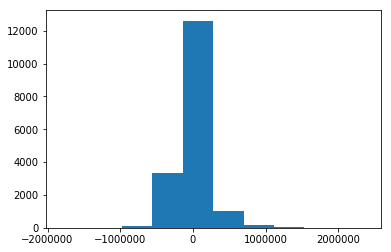

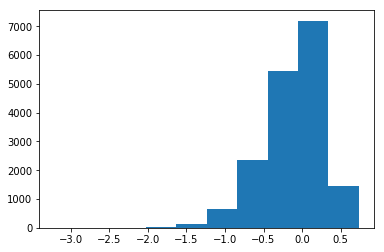

'Residuals vs price'

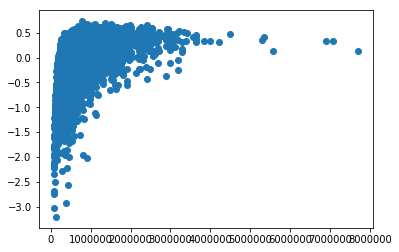

In [25]:
df_residuals = y_train.copy()
df_residuals['residual_norm'] = df_residuals.price - y_lr_train.values
df_residuals['residual_perc'] = (df_residuals.price - y_lr_train.values)/df_residuals.price
df_residuals['residual_perc_abs'] = np.abs(df_residuals.price - y_lr_train.values)/df_residuals.price


display("Distribution of residuals")
plt.hist(df_residuals['residual_norm'])
plt.show()
plt.hist(df_residuals['residual_perc'])
plt.show()

display("Residuals vs price")
plt.scatter(df_residuals.price, df_residuals.residual_perc)




__What you should see:__

* It didn't really help much...

## Add new data (income-level socioeconomic data)
* Load blockgroup-data
    * Blockgroup_avg_income_kc.csv
* Load csv that has transaltion function between lat-long and blockgroup
    * kc_blockgroup_lat_long.csv
* Join data:
    * Convert Lat-long to blockgroup
    * Join relevant blockgroup_demographic
* Explore data
* Re-run with LR

### Load blockgroup-data & lat_long pairs translation function





In [26]:
df_blockgroup_data = pd.read_csv('Blockgroup_avg_income_kc.csv', sep=',', header=0)

display(df_blockgroup_data.shape)
display(df_blockgroup_data.head(10))

df_blockgroup_pairs = pd.read_csv('kc_blockgroup_lat_long.csv', sep=',', header=0)
display(df_blockgroup_pairs.head(10))


(1422, 2)

,Blockgroup,Average_Income(USD)
0,530330001001,131601.12360
1,530330001002,53967.56329
2,530330001003,82872.80702
3,530330001004,38659.85577
4,530330001005,54125.59618
5,530330002001,84493.16629
6,530330002002,51479.40075
7,530330002003,60047.59239
8,530330002004,55213.29365
9,530330002005,72906.73212


,lat,long,block_key
0,47.5112,-122.257,5.303301e+11
1,47.7210,-122.319,5.303300e+11
2,47.7379,-122.233,5.303302e+11
3,47.5208,-122.393,5.303301e+11
4,47.6168,-122.045,5.303303e+11
5,47.6561,-122.005,5.303303e+11
6,47.3097,-122.327,5.303303e+11
7,47.4095,-122.315,5.303303e+11
8,47.5123,-122.337,5.303303e+11
9,47.3684,-122.031,5.303303e+11


### Join lat_long to blockgroup data to enable exploration

* Use merge to join blocgkroup_date with income and lat-long blockgroup dataframe
* Test for nulls and such

In [27]:
df_blockgorup_joined = pd.merge(df_blockgroup_data, df_blockgroup_pairs, left_on='Blockgroup', right_on = 'block_key')

display(df_blockgorup_joined.head(10))

df_blockgorup_joined.isnull().sum(axis = 0)

,Blockgroup,Average_Income(USD),lat,long,block_key
0,530330001001,131601.1236,47.7289,-122.283,5.303300e+11
1,530330001001,131601.1236,47.7293,-122.284,5.303300e+11
2,530330001001,131601.1236,47.7288,-122.284,5.303300e+11
3,530330001001,131601.1236,47.7281,-122.289,5.303300e+11
4,530330001001,131601.1236,47.7246,-122.284,5.303300e+11
5,530330001001,131601.1236,47.7211,-122.283,5.303300e+11
6,530330001001,131601.1236,47.7262,-122.285,5.303300e+11
7,530330001001,131601.1236,47.7328,-122.288,5.303300e+11
8,530330001001,131601.1236,47.7214,-122.285,5.303300e+11
9,530330001001,131601.1236,47.7303,-122.287,5.303300e+11


Blockgroup             0
Average_Income(USD)    0
lat                    0
long                   0
block_key              0
dtype: int64

### Explore data
* Compare lat-long income with lat-long average price of home per squarefoot
* Fun hack - you can just use scatter since lat and long are nicely linear (use long for X, and lat for y)
    * Then use color to see median income or average price
    * For housing data - probably best to color not by price but dollars per square foot of living space

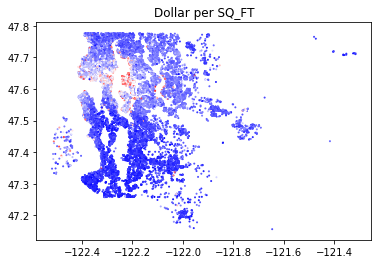

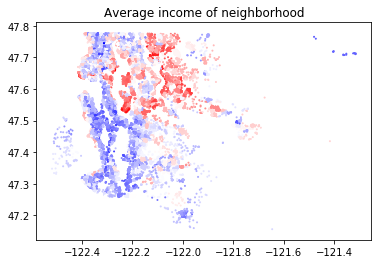

In [28]:
df_ll = df[['lat', 'long', 'sqft_living', 'price']].copy()
df_ll['usd_per_sqft'] = df_ll.price/df_ll.sqft_living

plt.scatter(df_ll.long, df_ll.lat, c=df_ll.usd_per_sqft, cmap='bwr',s=1)
plt.title("Dollar per SQ_FT")
plt.show()

plt.scatter(df_blockgorup_joined.long, 
            df_blockgorup_joined.lat, 
            c = df_blockgorup_joined['Average_Income(USD)'],
            cmap='bwr',
            s=1)
plt.title("Average income of neighborhood")
plt.show()


__What you should see:__

* there is a lot more disperity between two charts, but same general gradient
* Red is high, blue is low and we see similar hot-spots (i.e. around downtown Seattle)

## Re-run OLS with new Data

### Add lat_long_income into our data_set 

* Merge using multiple varialbes - you can simply supply left_on and right_on as a list of features to match
* check for nulls or that you got too many when you merge

In [29]:
df_clean_merge = pd.merge(df_clean, 
                          df_blockgorup_joined, 
                          how='left', 
                          left_on=['lat', 'long'], 
                          right_on=['lat', 'long'])

display(df_clean_merge.head(10))
display(df_clean_merge[df_clean_merge['Average_Income(USD)'] == 0].id.count())
display(df_clean_merge.shape)
display(df_clean_merge.isnull().sum(axis = 0))
df_clean_merge.dropna(inplace=True)
display(df_clean_merge.isnull().sum(axis = 0))



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,Blockgroup,Average_Income(USD),block_key
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,5.303301e+11,99876.39553,5.303301e+11
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,5.303300e+11,60047.59239,5.303300e+11
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,5.303302e+11,111770.46260,5.303302e+11
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,12,5.303301e+11,162528.93520,5.303301e+11
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,5.303303e+11,140467.12800,5.303303e+11
5,7237550310,2014-05-12,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930,5,5.303303e+11,153374.15540,5.303303e+11
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,6,5.303303e+11,72472.06704,5.303303e+11
7,2008000270,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,1,5.303303e+11,71209.50324,5.303303e+11
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113,4,5.303303e+11,37983.87097,5.303303e+11
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570,3,5.303303e+11,134708.20190,5.303303e+11


2

(21603, 25)

id                      0
date                    0
price                   0
bedrooms                0
bathrooms               0
sqft_living             0
sqft_lot                0
floors                  0
waterfront              0
view                    0
condition               0
grade                   0
sqft_above              0
sqft_basement           0
yr_built                0
yr_renovated            0
zipcode                 0
lat                     0
long                    0
sqft_living15           0
sqft_lot15              0
month                   0
Blockgroup             13
Average_Income(USD)    13
block_key              13
dtype: int64

id                     0
date                   0
price                  0
bedrooms               0
bathrooms              0
sqft_living            0
sqft_lot               0
floors                 0
waterfront             0
view                   0
condition              0
grade                  0
sqft_above             0
sqft_basement          0
yr_built               0
yr_renovated           0
zipcode                0
lat                    0
long                   0
sqft_living15          0
sqft_lot15             0
month                  0
Blockgroup             0
Average_Income(USD)    0
block_key              0
dtype: int64

__WARNING: You'll have 13 nulls, just drop for right now, but right thing to do would be to take average of 3 neareast ones...but we don't have time for that__

### Run new data set through our pipeline

In [30]:
preprocessing_steps_v4 = ([
    ('waterfront', None),
    (['bathrooms'], preprocessing.StandardScaler()),
    (['sqft_living'],[preprocessing.FunctionTransformer(square_x),preprocessing.StandardScaler()]),
    ('bedrooms', preprocessing.LabelBinarizer()),
    ('grade', preprocessing.LabelBinarizer()),
    (['yr_renovated'], [preprocessing.FunctionTransformer(yr_renovated_transform),preprocessing.LabelBinarizer()]),
    (['sqft_basement'], [preprocessing.FunctionTransformer(sqft_baseemnt_transform),preprocessing.LabelBinarizer()]),
    (['month'], preprocessing.LabelBinarizer()),
    (['Average_Income(USD)'], None)
])


mapper_features_v4 = DataFrameMapper(preprocessing_steps_v4)

np_transformed_features_s2_2 = mapper_features_v4.fit_transform(df_clean_merge.copy())
df_transformed_features_s2_2 = pd.DataFrame(data = np_transformed_features_s2_2, columns = mapper_features_v4.transformed_names_)


mapper_target_s2_2 = DataFrameMapper([(['price'],None)])
numpy_transform_target_s2_2 = mapper_target_s2_2.fit_transform(df_clean_merge[[TARGET]].copy())

df_transformed_target_s2_2 = pd.DataFrame(data = numpy_transform_target_s2_2, columns = ['price'])

C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by valida

### Train using new data with OLS, show coefficients and also calculate MAPE and MAE

In [31]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features_s2_2, df_transformed_target_s2_2, test_size=0.2, random_state=42)

# X_train.isnull().sum(axis = 0)

sm_lm_model_s2_2 = sm.OLS(y_train, sm.add_constant(X_train))

sm_lm_model_fit_s2_2 = sm_lm_model_s2_2.fit()

display(sm_lm_model_fit_s2_2.summary())

y_lr_train = sm_lm_model_fit_s2_2.predict(sm.add_constant(X_train))
y_lr_test = sm_lm_model_fit_s2_2.predict(sm.add_constant(X_test))

# display(Markdown('###### Performance on training set'))
display('Linear model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train.values.ravel(), y_lr_train.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_train.values.ravel(), y_lr_train.values)*100))

# display(Markdown('###### Performance on test set'))
display('Linear model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test.values.ravel(), y_lr_test.values)))
display('Linear model train set MAPE: {:.4f}%'.format(mean_absolute_percentage_error(y_test.values.ravel(), y_lr_test.values)*100))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     812.5
Date:                Tue, 11 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:27:48   Log-Likelihood:            -2.3540e+05
No. Observations:               17272   AIC:                         4.709e+05
Df Residuals:                   17223   BIC:                         4.713e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.819e+05   3.31e+04     14.570      0.000    4.17e+05    5.47e+05
waterfront           7.103e+05   1.84e+04     38.534      0.000    6.74e+05    7.46e+05
bathrooms           -7346.8762   2468.273     -2.977      0.003   -1.22e+04   -2508.809
sqft_living          1.456e+05   3303.127     44.071      0.000    1.39e+05    1.52e+05
bedrooms_0           4401.3786   8.54e+04      0.052      0.959   -1.63e+05    1.72e+05
bedrooms_1           3.549e+04    2.4e+04      1.478      0.139   -1.16e+04    8.25e+04
bedrooms_2           5.165e+04    1.9e+04      2.722      0.006    1.45e+04    8.89e+04
bedrooms_3           1.711e+04   1.85e+04      0.923      0.356   -1.92e+04    5.35e+04
bedrooms_4          -1482.7300   1.85e+04     -0.080      0.936   -3.78e+04    3.49e+04
bedrooms_5           2.389e+04    1.9e+04      1.256      0.209   -1.34e+04    6.12e+04
bedrooms_6           4.408e+04   2.23e+04      1.977      0.048     370.451    8.78e+04
bedrooms_7           -1.95e+04   3.83e+04     -0.510      0.610   -9.45e+04    5.55e+04
bedrooms_8           2.779e+05   5.61e+04      4.952      0.000    1.68e+05    3.88e+05
bedrooms_9           2.753e+04   9.36e+04      0.294      0.769   -1.56e+05    2.11e+05
bedrooms_10          2.087e+04   1.31e+05      0.159      0.874   -2.36e+05    2.78e+05
bedrooms_11         -9.209e-07   1.75e-07     -5.258      0.000   -1.26e-06   -5.78e-07
grade_3             -2.306e+05   1.85e+05     -1.248      0.212   -5.93e+05    1.31e+05
grade_4             -3.593e+05   4.53e+04     -7.929      0.000   -4.48e+05    -2.7e+05
grade_5             -2.919e+05   2.36e+04    -12.395      0.000   -3.38e+05   -2.46e+05
grade_6             -2.669e+05      2e+04    -13.322      0.000   -3.06e+05   -2.28e+05
grade_7             -2.348e+05   1.95e+04    -12.023      0.000   -2.73e+05   -1.97e+05
grade_8             -1.795e+05   1.95e+04     -9.214      0.000   -2.18e+05   -1.41e+05
grade_9             -8.222e+04   1.96e+04     -4.198      0.000   -1.21e+05   -4.38e+04
grade_10             5.398e+04   2.02e+04      2.678      0.007    1.45e+04    9.35e+04
grade_11             2.159e+05   2.23e+04      9.669      0.000    1.72e+05     2.6e+05
grade_12             5.655e+05   3.03e+04     18.668      0.000    5.06e+05    6.25e+05
grade_13             1.292e+06   6.02e+04     21.476      0.000    1.17e+06    1.41e+06
yr_renovated_0      -3.156e+04   1.21e+04     -2.617      0.009   -5.52e+04   -7921.986
yr_renovated_1       3.296e+04   6.89e+04      0.479      0.632   -1.02e+05    1.68e+05
yr_renovated_2       3.321e+04   4.78e+04      0.694      0.487   -6.05e+04    1.27e+05
yr_renovated_3      -4.325e+04   3.93e+04     -1.100      0.271    -1.2e+05    3.38e+04
yr_renovated_4        4.31e+04   3.02e+04      1.429      0.153    -1.6e+04    1.02e+05
yr_

'Linear model train set MAE: $132130'

'Linear model train set MAPE: 26.4090%'

'Linear model test set MAE: $139150'

'Linear model train set MAPE: 26.5903%'

__What you should see:__
    
* Adjusted R2 improved by ~5% which is also very good
* MAPE improved by ~4% which is pretty good

### Explore error

'Distribution of residuals'

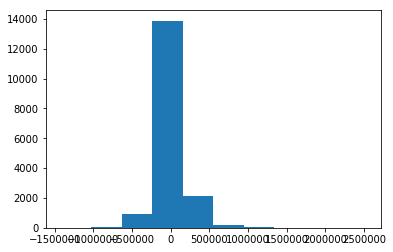

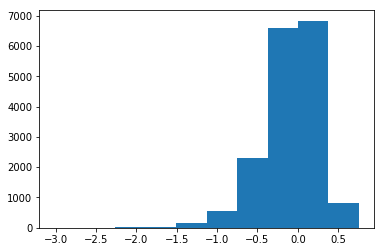

'Residuals vs price'

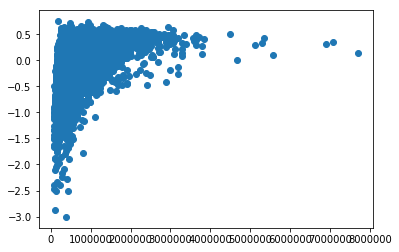

In [32]:
df_residuals = y_train.copy()
df_residuals['residual_norm'] = df_residuals.price - y_lr_train.values
df_residuals['residual_perc'] = (df_residuals.price - y_lr_train.values)/df_residuals.price
df_residuals['residual_perc_abs'] = np.abs(df_residuals.price - y_lr_train.values)/df_residuals.price


display("Distribution of residuals")
plt.hist(df_residuals['residual_norm'])
plt.show()
plt.hist(df_residuals['residual_perc'])
plt.show()

display("Residuals vs price")
plt.scatter(df_residuals.price, df_residuals.residual_perc)




__What you should see:__

* We continue to struggle with homoskedcity

## Try more sophisticated model - XGBoost

### Re-train XGRegressor using existing data pipeline 

In [33]:
# from xgboost import XGBRegressor
XG_model = XGBRegressor()

XG_model.fit(X_train, y_train)

y_xg_train = XG_model.predict(X_train)
y_xg_train = np.reshape(y_xg_train, (-1, 1))
y_xg_test = XG_model.predict(X_test)
y_xg_test = np.reshape(y_xg_test, (-1, 1))


display(Markdown('###### Performance on training set'))

display('XGBoost model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train, y_xg_train)))
display('XGBoost model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_train.values, y_xg_train)*100))

display(Markdown('###### Performance on test set'))

display('XGBoost model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test, y_xg_test)))
display('XGBoost model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test.values, y_xg_test)*100))

display(Markdown('###### Coefficients'))

FEATURES = mapper_features_v4.transformed_names_

pd.DataFrame({'features': FEATURES, 'importance': XG_model.feature_importances_}).sort_values('importance', ascending=False)

###### Performance on training set

'XGBoost model train set MAE: $123292'

'XGBoost model train set MAPE: 25.66%'

###### Performance on test set

'XGBoost model test set MAE: $132777'

'XGBoost model train set MAPE: 26.17%'

###### Coefficients

,features,importance
2,sqft_living,0.243202
53,Average_Income(USD),0.226586
1,bathrooms,0.114804
0,waterfront,0.052870
26,yr_renovated_0,0.045317
22,grade_10,0.036254
35,sqft_basement_0,0.033233
23,grade_11,0.031722
24,grade_12,0.028701
21,grade_9,0.027190


__What you should see:__

* MAPE of about 26% - only 0.5% better than the linear regression
* Coefficient stength - looks like average income raises to the top, so it's possible that XGB could find some value in some of the data we decided to leave out - we should try that next


### Add a bit more data into our pipeline

* lat, long
* view - was weak relationship



In [34]:
preprocessing_steps_s2_3 = ([
    ('waterfront', None),
    (['bathrooms'], preprocessing.StandardScaler()),
    (['sqft_living'],[preprocessing.FunctionTransformer(square_x),preprocessing.StandardScaler()]),
    ('bedrooms', preprocessing.LabelBinarizer()),
    ('grade', preprocessing.LabelBinarizer()),
    (['yr_renovated'], [preprocessing.FunctionTransformer(yr_renovated_transform),preprocessing.LabelBinarizer()]),
    (['sqft_basement'], [preprocessing.FunctionTransformer(sqft_baseemnt_transform),preprocessing.LabelBinarizer()]),
    (['month'], preprocessing.LabelBinarizer()),
    (['Average_Income(USD)'], None),
    (['lat'], None),
    (['long'], None),
    (['view'], None),
])


mapper_features_s2_3 = DataFrameMapper(preprocessing_steps_s2_3)

np_transformed_features_s2_3 = mapper_features_s2_3.fit_transform(df_clean_merge.copy())
df_transformed_features_s2_3 = pd.DataFrame(data = np_transformed_features_s2_3, columns = mapper_features_s2_3.transformed_names_)

C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ML\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by valida

### Re-train XGBoost, show coefficients and calculate MAPE and MAE

In [35]:
# The function train_test_split, splits the arguments into two sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_transformed_features_s2_3, df_transformed_target_s2_2, test_size=0.2, random_state=42)

XG_model.fit(X_train, y_train)

y_xg_train = XG_model.predict(X_train)
y_xg_train = np.reshape(y_xg_train, (-1, 1))
y_xg_test = XG_model.predict(X_test)
y_xg_test = np.reshape(y_xg_test, (-1, 1))


display(Markdown('###### Performance on training set'))

display('XGBoost model train set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_train, y_xg_train)))
display('XGBoost model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_train.values, y_xg_train)*100))

display(Markdown('###### Performance on test set'))

display('XGBoost model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test, y_xg_test)))
display('XGBoost model train set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test.values, y_xg_test)*100))

display(Markdown('###### Coefficients'))

FEATURES = mapper_features_s2_3.transformed_names_

pd.DataFrame({'features': FEATURES, 'importance': XG_model.feature_importances_}).sort_values('importance', ascending=False)


###### Performance on training set

'XGBoost model train set MAE: $77589'

'XGBoost model train set MAPE: 15.25%'

###### Performance on test set

'XGBoost model test set MAE: $85103'

'XGBoost model train set MAPE: 15.86%'

###### Coefficients

,features,importance
2,sqft_living,0.238938
54,lat,0.216814
55,long,0.134218
53,Average_Income(USD),0.070796
56,view,0.047198
0,waterfront,0.033923
1,bathrooms,0.032448
22,grade_10,0.029499
24,grade_12,0.029499
23,grade_11,0.025074


__What you should see:__

* Huge improvement - added 10%+ of accuracy and lat, and long are 2nd and 3rd most importnat feature
* view climbed pretty high to the list of things that matter

### Explore error

'Distribution of residuals'

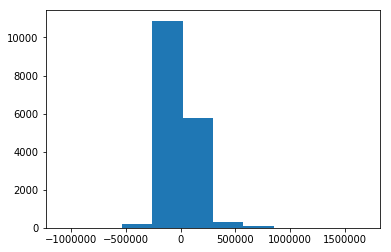

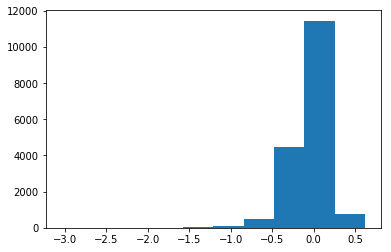

'Residuals vs price'

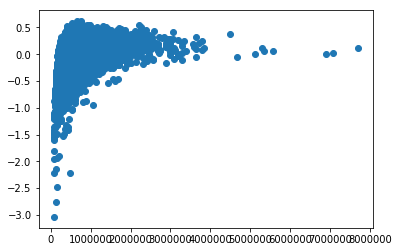

In [36]:
df_residuals = y_train.copy()


df_residuals['residual_norm'] = df_residuals.price - y_xg_train.flatten()

df_residuals['residual_perc'] = (df_residuals.price - y_xg_train.flatten())/df_residuals.price
df_residuals['residual_perc_abs'] = np.abs(df_residuals.price - y_xg_train.flatten())/df_residuals.price


display("Distribution of residuals")
plt.hist(df_residuals['residual_norm'])
plt.show()
plt.hist(df_residuals['residual_perc'])
plt.show()

display("Residuals vs price")
plt.scatter(df_residuals.price, df_residuals.residual_perc)




__What you should see:__

* Remarkably our issue with homes that are less expensive exists even with xgboost
* It must be that we're simply missing an important predictor variable 

## Hyperparameter tuning

### Let's play with depth only

* Create a list of depths (e.g. from 3 to 15)
* Run for-loop wher we re-train with different depth
* See which one does best

'Trained with max-depth of 3.000000 and MAPE is 15.859685%'

'Trained with max-depth of 4.000000 and MAPE is 14.873058%'

'Trained with max-depth of 5.000000 and MAPE is 14.231725%'

'Trained with max-depth of 6.000000 and MAPE is 13.707905%'

'Trained with max-depth of 7.000000 and MAPE is 13.466882%'

'Trained with max-depth of 8.000000 and MAPE is 13.314733%'

'Trained with max-depth of 9.000000 and MAPE is 13.376963%'

'Trained with max-depth of 10.000000 and MAPE is 13.305892%'

'Trained with max-depth of 11.000000 and MAPE is 13.476825%'

'Trained with max-depth of 12.000000 and MAPE is 13.432542%'

'Trained with max-depth of 13.000000 and MAPE is 13.427465%'

'Trained with max-depth of 14.000000 and MAPE is 13.586360%'

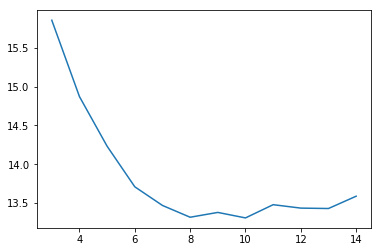

In [37]:
max_depth_list = list(range(3,15))
test_MAPE = []

for max_depth in max_depth_list:
    XG_model_tuned = XGBRegressor(max_depth = max_depth)
    XG_model_tuned.fit(X_train, y_train)
    
    y_xg_test = XG_model_tuned.predict(X_test)
    y_xg_test = np.reshape(y_xg_test, (-1, 1))
    
    MAPE = mean_absolute_percentage_error(y_test.values, y_xg_test)*100
    display('Trained with max-depth of {:0f} and MAPE is {:2f}%'.format(max_depth,MAPE ))
    test_MAPE.append(MAPE)
    
plt.plot(max_depth_list, test_MAPE)
    


#     display(Markdown('### Max_Depth = {:0f}'.format(max_depth_increment)))
#     display(Markdown('###### Performance on test set'))

#     display('XGBoost model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test, y_xg_test)))
#     display('XGBoost model test set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test.values, y_xg_test)*100))

__What you should see:__

* loks like depth of 10 is pretty sweet - reduces error by ~3%
* this is not surprising at all since suspect lat and long play occupy a large part of those trees to isolate neighbourhoods where similar houses get higher price

### Let's try to play with n_estimators

* similar to above, go from 50 to 500 in incremenets of 50

'Trained with n_estimators of 50.000000 and MAPE is 13.383422%'

'Trained with n_estimators of 100.000000 and MAPE is 13.305892%'

'Trained with n_estimators of 150.000000 and MAPE is 13.251031%'

'Trained with n_estimators of 200.000000 and MAPE is 13.231913%'

'Trained with n_estimators of 250.000000 and MAPE is 13.227655%'

'Trained with n_estimators of 300.000000 and MAPE is 13.245373%'

'Trained with n_estimators of 350.000000 and MAPE is 13.272413%'

'Trained with n_estimators of 400.000000 and MAPE is 13.288379%'

'Trained with n_estimators of 450.000000 and MAPE is 13.326370%'

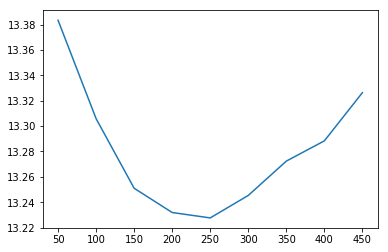

In [38]:
estimators_list = list(range(50,500,50))
test_MAPE = []

for n_estimators in estimators_list:
    XG_model_tuned = XGBRegressor(max_depth = 10, n_estimators = n_estimators)
    XG_model_tuned.fit(X_train, y_train)
    
    y_xg_test = XG_model_tuned.predict(X_test)
    y_xg_test = np.reshape(y_xg_test, (-1, 1))
    
    MAPE = mean_absolute_percentage_error(y_test.values, y_xg_test)*100
    display('Trained with n_estimators of {:0f} and MAPE is {:2f}%'.format(n_estimators,MAPE ))
    test_MAPE.append(MAPE)
    
plt.plot(estimators_list, test_MAPE)
    


#     display(Markdown('### Max_Depth = {:0f}'.format(max_depth_increment)))
#     display(Markdown('###### Performance on test set'))

#     display('XGBoost model test set MAE: ${:.0f}'.format(sklearn.metrics.mean_absolute_error(y_test, y_xg_test)))
#     display('XGBoost model test set MAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test.values, y_xg_test)*100))

__What you should see:__

* n_estimators of 250 seems like the sweet spot, but only reduced error by 0.07%
* Our new error is now 13%
* We should stop with hyper-parameter tuning now...